In [104]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import matplotlib.patches as mpatches
import folium
from folium.plugins import HeatMap
import mapclassify

In [105]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_gps = pd.read_sql('select cable_id,geometry from cable_distance;',con=con)
# gpd_cable_gps = gpd.GeoDataFrame(cable_gps,geometry=cable_gps['geometry'])

In [106]:
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
worldMap=worldMap[worldMap['continent'] != 'Antarctica']
worldMap.loc[worldMap['name'] == 'France', 'iso_a3'] = 'FRA'
worldMap.loc[worldMap['name'] == 'Norway', 'iso_a3'] = 'NOR'
worldMap.loc[worldMap['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
worldMap.loc[worldMap['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
worldMap.loc[worldMap['name'] == 'Kosovo', 'iso_a3'] = 'RKS'
worldMap

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    RKS     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[176 rows x 6 columns]

<AxesSubplot:>

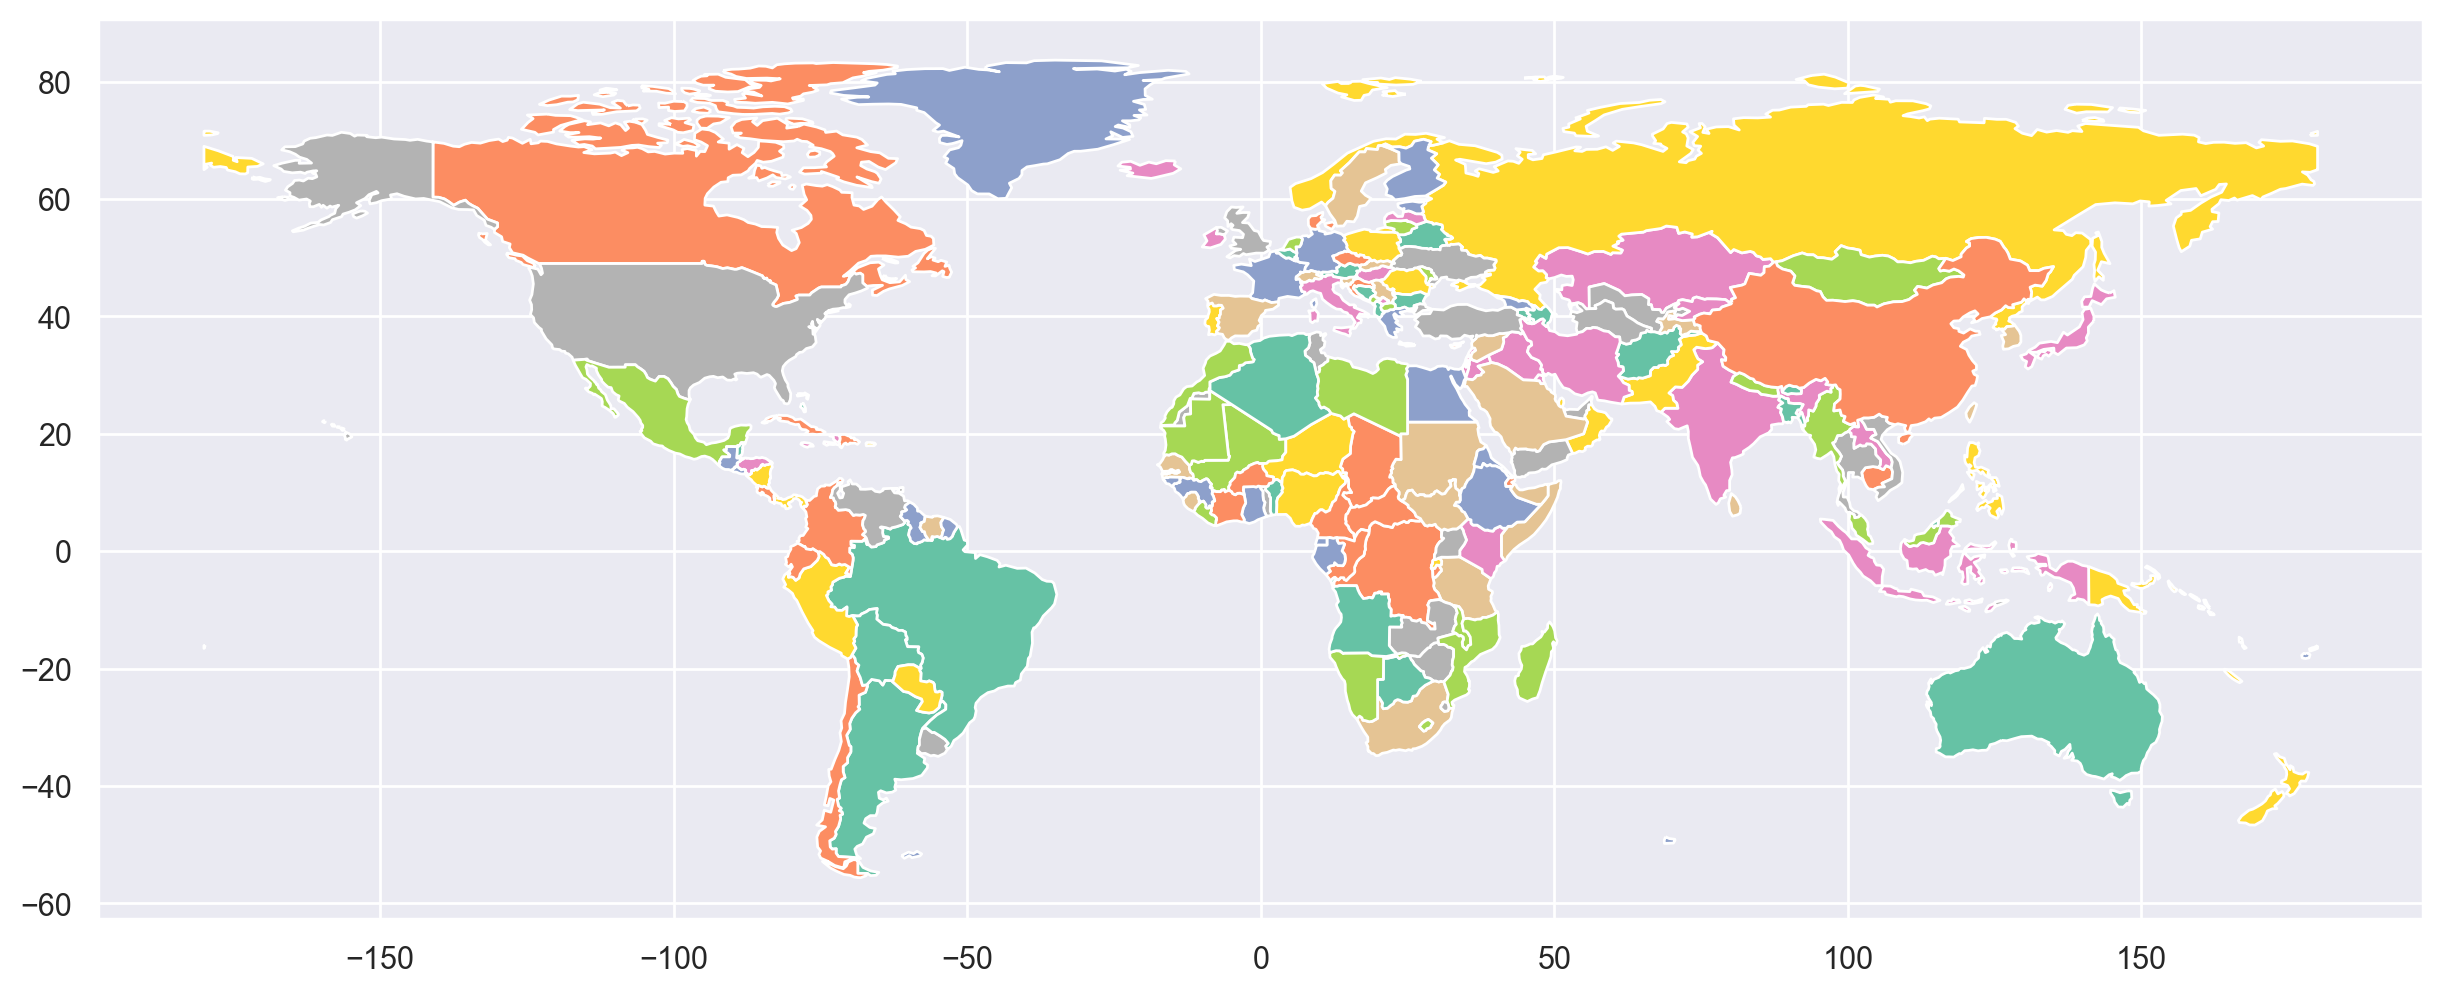

In [107]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column='name', ax=ax, legend=False,cmap='Set2',aspect=1,legend_kwds={'loc': 'lower left'})
# gpd_cable_gps.plot(column='cable_id',ax=ax, cmap='Set3')

In [108]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    first_cable = pd.read_sql('select landingPoint_country, cc."alpha-3" as alpha_3,cc."alpha-2" as alpha_2, min(cable_finish_year) as first_cable_year from landing_points lp left join world_countries wc on lp.landingPoint_country = wc.name left join country_code cc on wc.code = cc."alpha-2" where cc."alpha-3" is not null group by lp.landingPoint_country order by cable_finish_year desc;',con=con)
first_cable_merged = first_cable.merge(right=worldMap, how='right',left_on='alpha_3', right_on='iso_a3')
first_cable_merged

landingPoint_country alpha_3 alpha_2  first_cable_year    pop_est  \
0                   Fiji     FJI      FJ            2000.0     920938   
1               Tanzania     TZA      TZ            2009.0   53950935   
2                    NaN     NaN     NaN               NaN     603253   
3                 Canada     CAN      CA            2001.0   35623680   
4          United States     USA      US            1992.0  326625791   
..                   ...     ...     ...               ...        ...   
171                  NaN     NaN     NaN               NaN    7111024   
172                  NaN     NaN     NaN               NaN     642550   
173                  NaN     NaN     NaN               NaN    1895250   
174  Trinidad and Tobago     TTO      TT            1995.0    1218208   
175                  NaN     NaN     NaN               NaN   13026129   

         continent                      name iso_a3  gdp_md_est  \
0          Oceania                      Fiji    FJI      8374.0   
1           Africa                  Tanzania    TZA    150600.0   
2           Africa                 W. Sahara    ESH       906.5   
3    North America                    Canada    CAN   1674000.0   
4    North America  United States of America    USA  18560000.0   
..             ...                       ...    ...         ...   
171         Europe                    Serbia    SRB    101800.0   
172         Europe                Montenegro    MNE     10610.0   
173         Europe                    Kosovo    RKS     18490.0   
174  North America       Trinidad and Tobago    TTO     43570.0   
175         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
171  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
172  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
173  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
174  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
175  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[176 rows x 10 columns]

In [109]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

<AxesSubplot:>

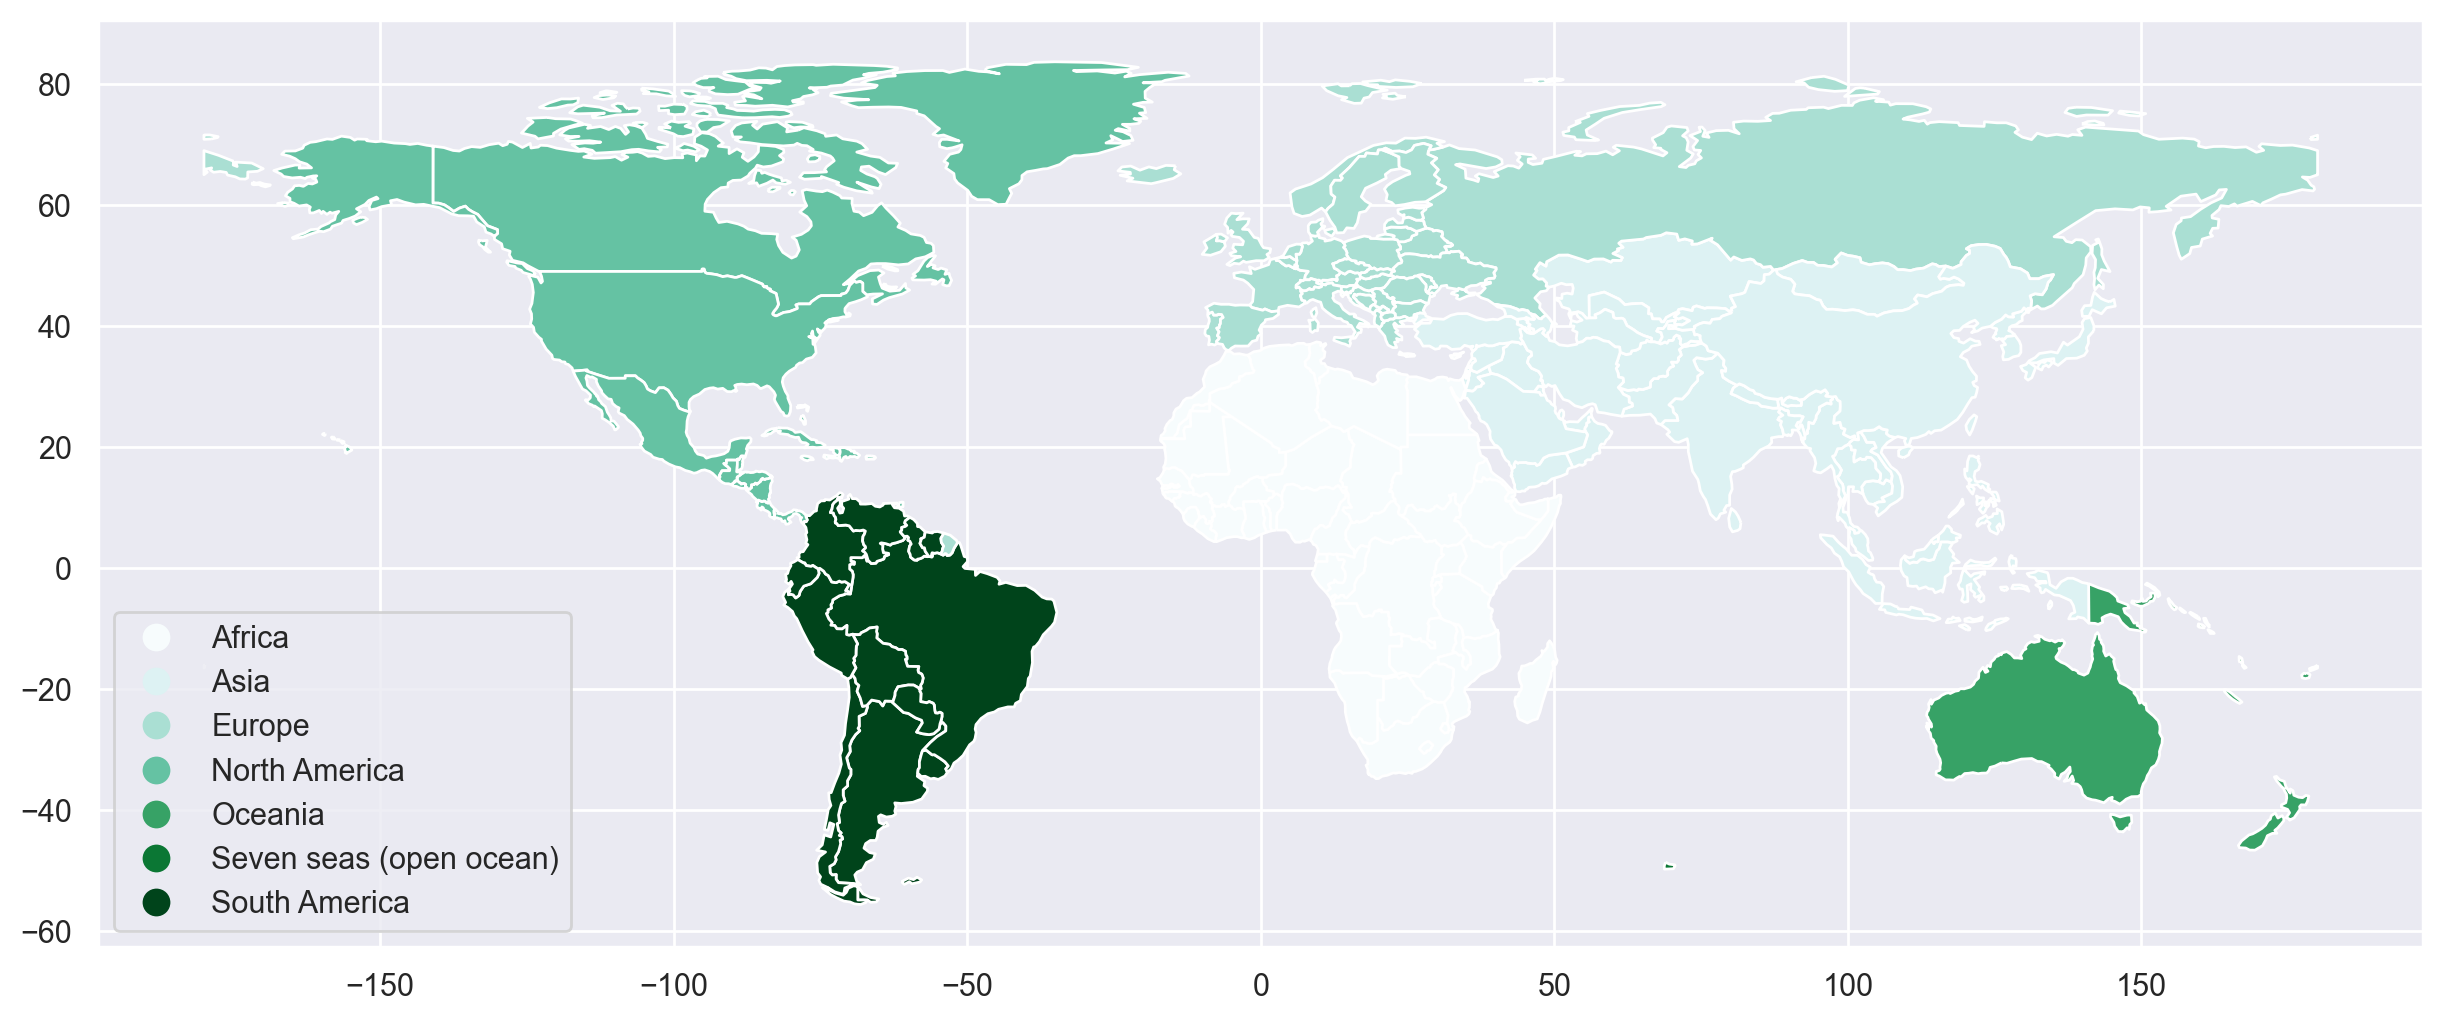

In [110]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
# first_cable_merged.plot(column='continent', ax=ax, legend=True, cmap='Set2',aspect=1)
worldMap.plot(worldMap['continent'], cmap='BuGn', legend=True, ax=ax,legend_kwds={'loc': 'lower left'})
# legend_kwds={'bbox_to_anchor':(0.1, 0.5)}

(-198.0, 198.00000000000006, -62.574678, 90.607978)

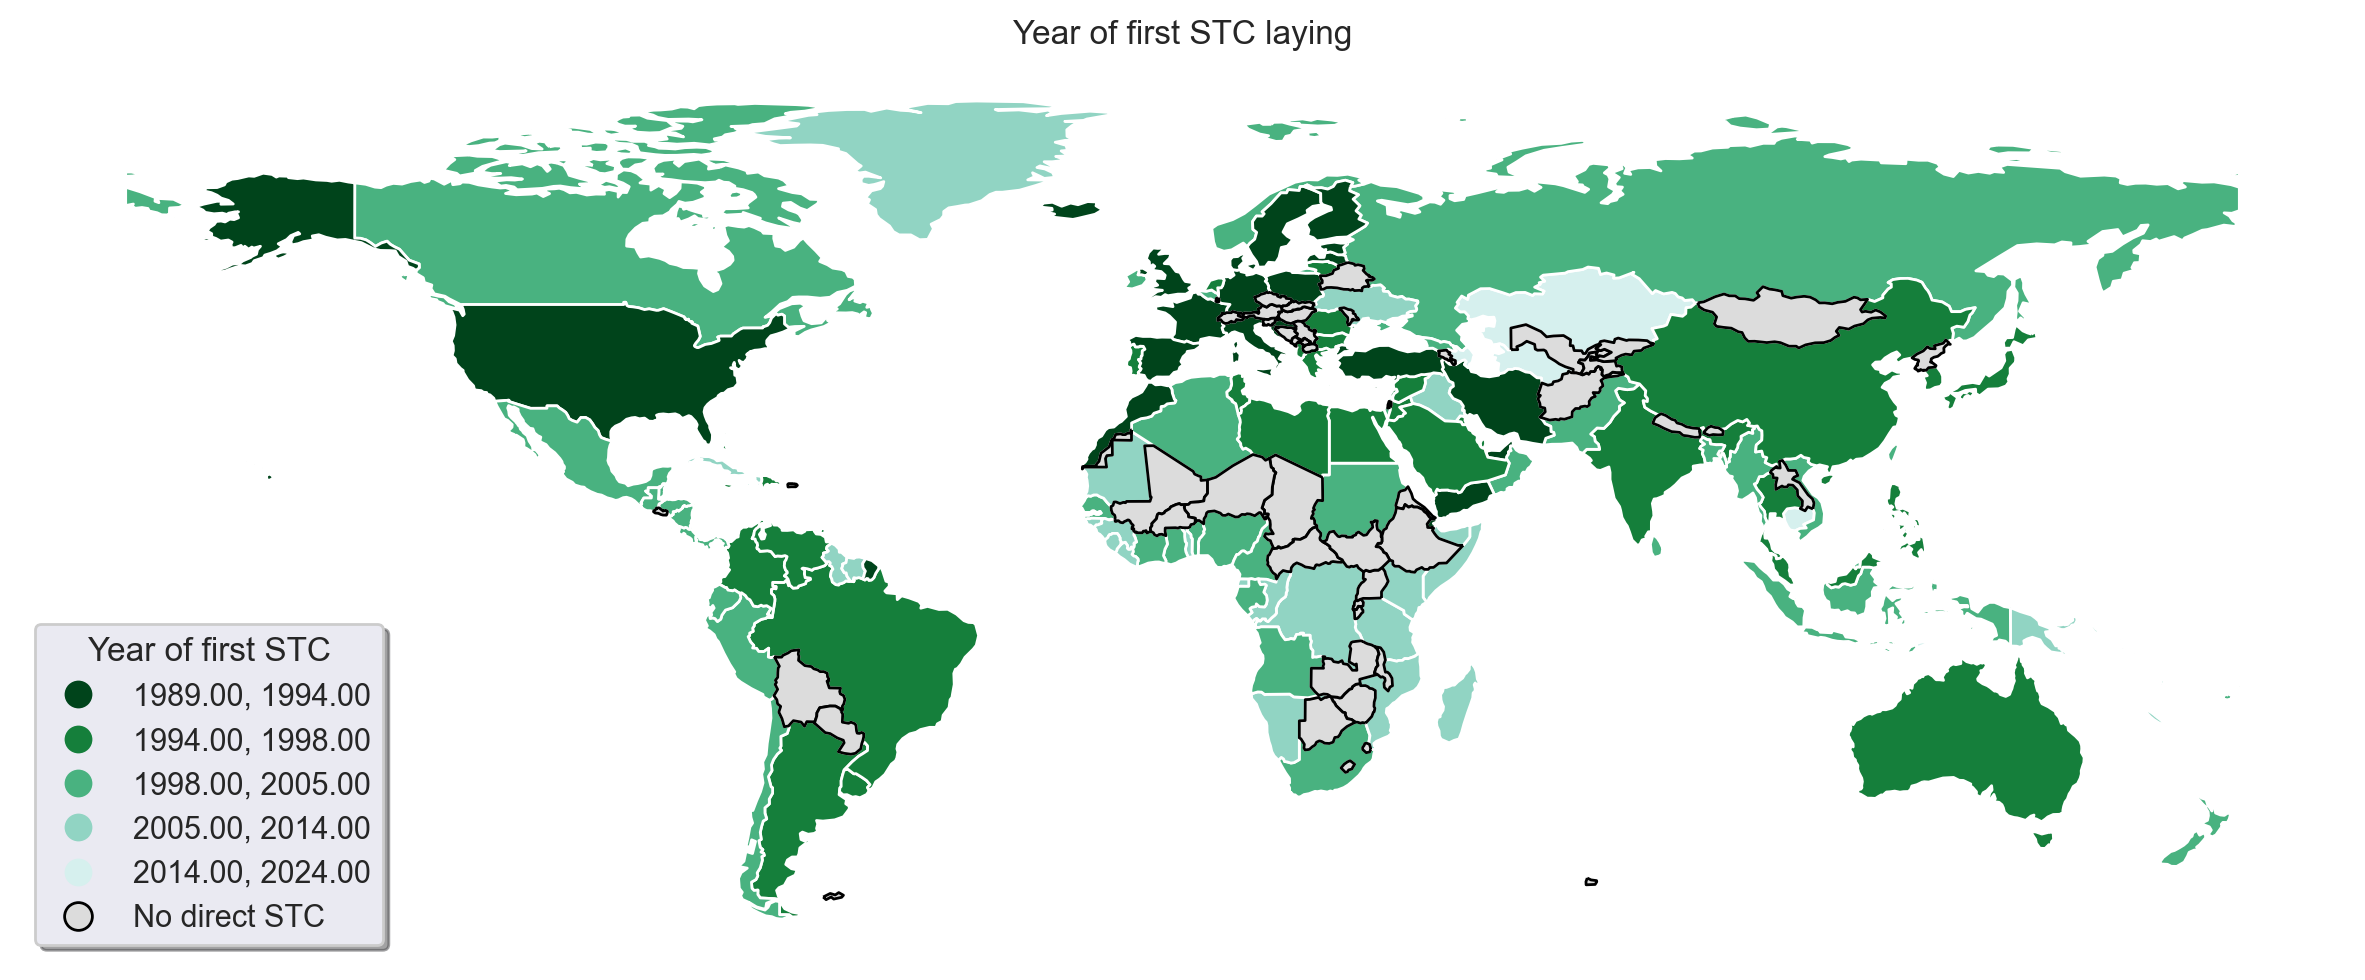

In [111]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf = gpd.GeoDataFrame(first_cable_merged, geometry='geometry')

orig_BuGn=plt.cm.get_cmap('BuGn')
orig_BuGn = truncate_colormap(orig_BuGn, 0.2, 1)

reversed_BuGn = orig_BuGn.reversed()
gdf.plot(gdf['first_cable_year'],  cmap=reversed_BuGn, missing_kwds={
"color": "gainsboro",
"edgecolor": "black",
"hatch": "",
"label": "No direct STC"
},legend=True, ax=ax,scheme='NaturalBreaks',k=5,legend_kwds={'loc': 'lower left','title': 'Year of first STC','shadow': True})
# ax.legend(title="图例", loc='lower left', ncol=1, shadow=True)
plt.title('Year of first STC laying')
ax.axis('off')


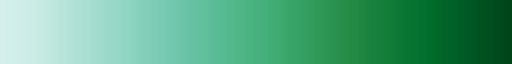

In [112]:
orig_BuGn

In [113]:
worldMap = gpd.read_file('../worldMap.geojson')
# worldMap=worldMap[worldMap['continent'] != 'Antarctica']
worldMap

FID                               COUNTRY ISO          COUNTRYAFF  \
0      1                        American Samoa  AS       United States   
1      2  United States Minor Outlying Islands  UM       United States   
2      3                          Cook Islands  CK         New Zealand   
3      4                      French Polynesia  PF              France   
4      5                                  Niue  NU         New Zealand   
..   ...                                   ...  ..                 ...   
244  245              Northern Mariana Islands  MP       United States   
245  246                                 Palau  PW               Palau   
246  247                    Russian Federation  RU  Russian Federation   
247  248                                 Spain  ES               Spain   
248  249                              Canarias  ES               Spain   

    AFF_ISO   SHAPE_Leng   SHAPE_Area  \
0        US     0.600124     0.013720   
1        US     0.480216     0.003216   
2        NZ     0.980664     0.013073   
3        FR     3.930211     0.175332   
4        NZ     0.541413     0.021414   
..      ...          ...          ...   
244      US     0.908853     0.019927   
245      PW     1.105323     0.031136   
246      RU  1536.287150  2931.526082   
247      ES    51.724956    52.915449   
248      ES     9.491474     0.695336   

                                              geometry  
0    MULTIPOLYGON (((-170.74390 -14.37555, -170.749...  
1    MULTIPOLYGON (((-160.02114 -0.39805, -160.0281...  
2    MULTIPOLYGON (((-159.74698 -21.25667, -159.793...  
3    MULTIPOLYGON (((-149.17920 -17.87084, -149.258...  
4    MULTIPOLYGON (((-169.89389 -19.14556, -169.930...  
..                                                 ...  
244  MULTIPOLYGON (((145.73468 15.08722, 145.72830 ...  
245  MULTIPOLYGON (((134.53137 7.35444, 134.52234 7...  
246  MULTIPOLYGON (((-179.99999 68.98010, -179.9580...  
247  MULTIPOLYGON (((-2.91472 35.27361, -2.93924 35...  
248  MULTIPOLYGON (((-17.91125 27.77374, -17.96389 ...  

[249 rows x 8 columns]

In [114]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    first_cable = pd.read_sql('select landingPoint_country, cc."alpha-3" as alpha_3,cc."alpha-2" as alpha_2, min(cable_finish_year) as first_cable_year from landing_points lp left join world_countries wc on lp.landingPoint_country = wc.name left join country_code cc on wc.code = cc."alpha-2" where cc."alpha-3" is not null group by lp.landingPoint_country order by cable_finish_year desc;',con=con)
first_cable_merged = first_cable.merge(right=worldMap, how='right',left_on='alpha_2', right_on='AFF_ISO')
first_cable_merged

landingPoint_country alpha_3 alpha_2  first_cable_year  FID  \
0          United States     USA      US            1992.0    1   
1          United States     USA      US            1992.0    2   
2            New Zealand     NZL      NZ            2000.0    3   
3                 France     FRA      FR            1992.0    4   
4            New Zealand     NZL      NZ            2000.0    5   
..                   ...     ...     ...               ...  ...   
244        United States     USA      US            1992.0  245   
245                Palau     PLW      PW            2017.0  246   
246               Russia     RUS      RU            2000.0  247   
247                Spain     ESP      ES            1990.0  248   
248                Spain     ESP      ES            1990.0  249   

                                  COUNTRY ISO          COUNTRYAFF AFF_ISO  \
0                          American Samoa  AS       United States      US   
1    United States Minor Outlying Islands  UM       United States      US   
2                            Cook Islands  CK         New Zealand      NZ   
3                        French Polynesia  PF              France      FR   
4                                    Niue  NU         New Zealand      NZ   
..                                    ...  ..                 ...     ...   
244              Northern Mariana Islands  MP       United States      US   
245                                 Palau  PW               Palau      PW   
246                    Russian Federation  RU  Russian Federation      RU   
247                                 Spain  ES               Spain      ES   
248                              Canarias  ES               Spain      ES   

      SHAPE_Leng   SHAPE_Area  \
0       0.600124     0.013720   
1       0.480216     0.003216   
2       0.980664     0.013073   
3       3.930211     0.175332   
4       0.541413     0.021414   
..           ...          ...   
244     0.908853     0.019927   
245     1.105323     0.031136   
246  1536.287150  2931.526082   
247    51.724956    52.915449   
248     9.491474     0.695336   

                                              geometry  
0    MULTIPOLYGON (((-170.74390 -14.37555, -170.749...  
1    MULTIPOLYGON (((-160.02114 -0.39805, -160.0281...  
2    MULTIPOLYGON (((-159.74698 -21.25667, -159.793...  
3    MULTIPOLYGON (((-149.17920 -17.87084, -149.258...  
4    MULTIPOLYGON (((-169.89389 -19.14556, -169.930...  
..                                                 ...  
244  MULTIPOLYGON (((145.73468 15.08722, 145.72830 ...  
245  MULTIPOLYGON (((134.53137 7.35444, 134.52234 7...  
246  MULTIPOLYGON (((-179.99999 68.98010, -179.9580...  
247  MULTIPOLYGON (((-2.91472 35.27361, -2.93924 35...  
248  MULTIPOLYGON (((-17.91125 27.77374, -17.96389 ...  

[249 rows x 12 columns]

<AxesSubplot:>

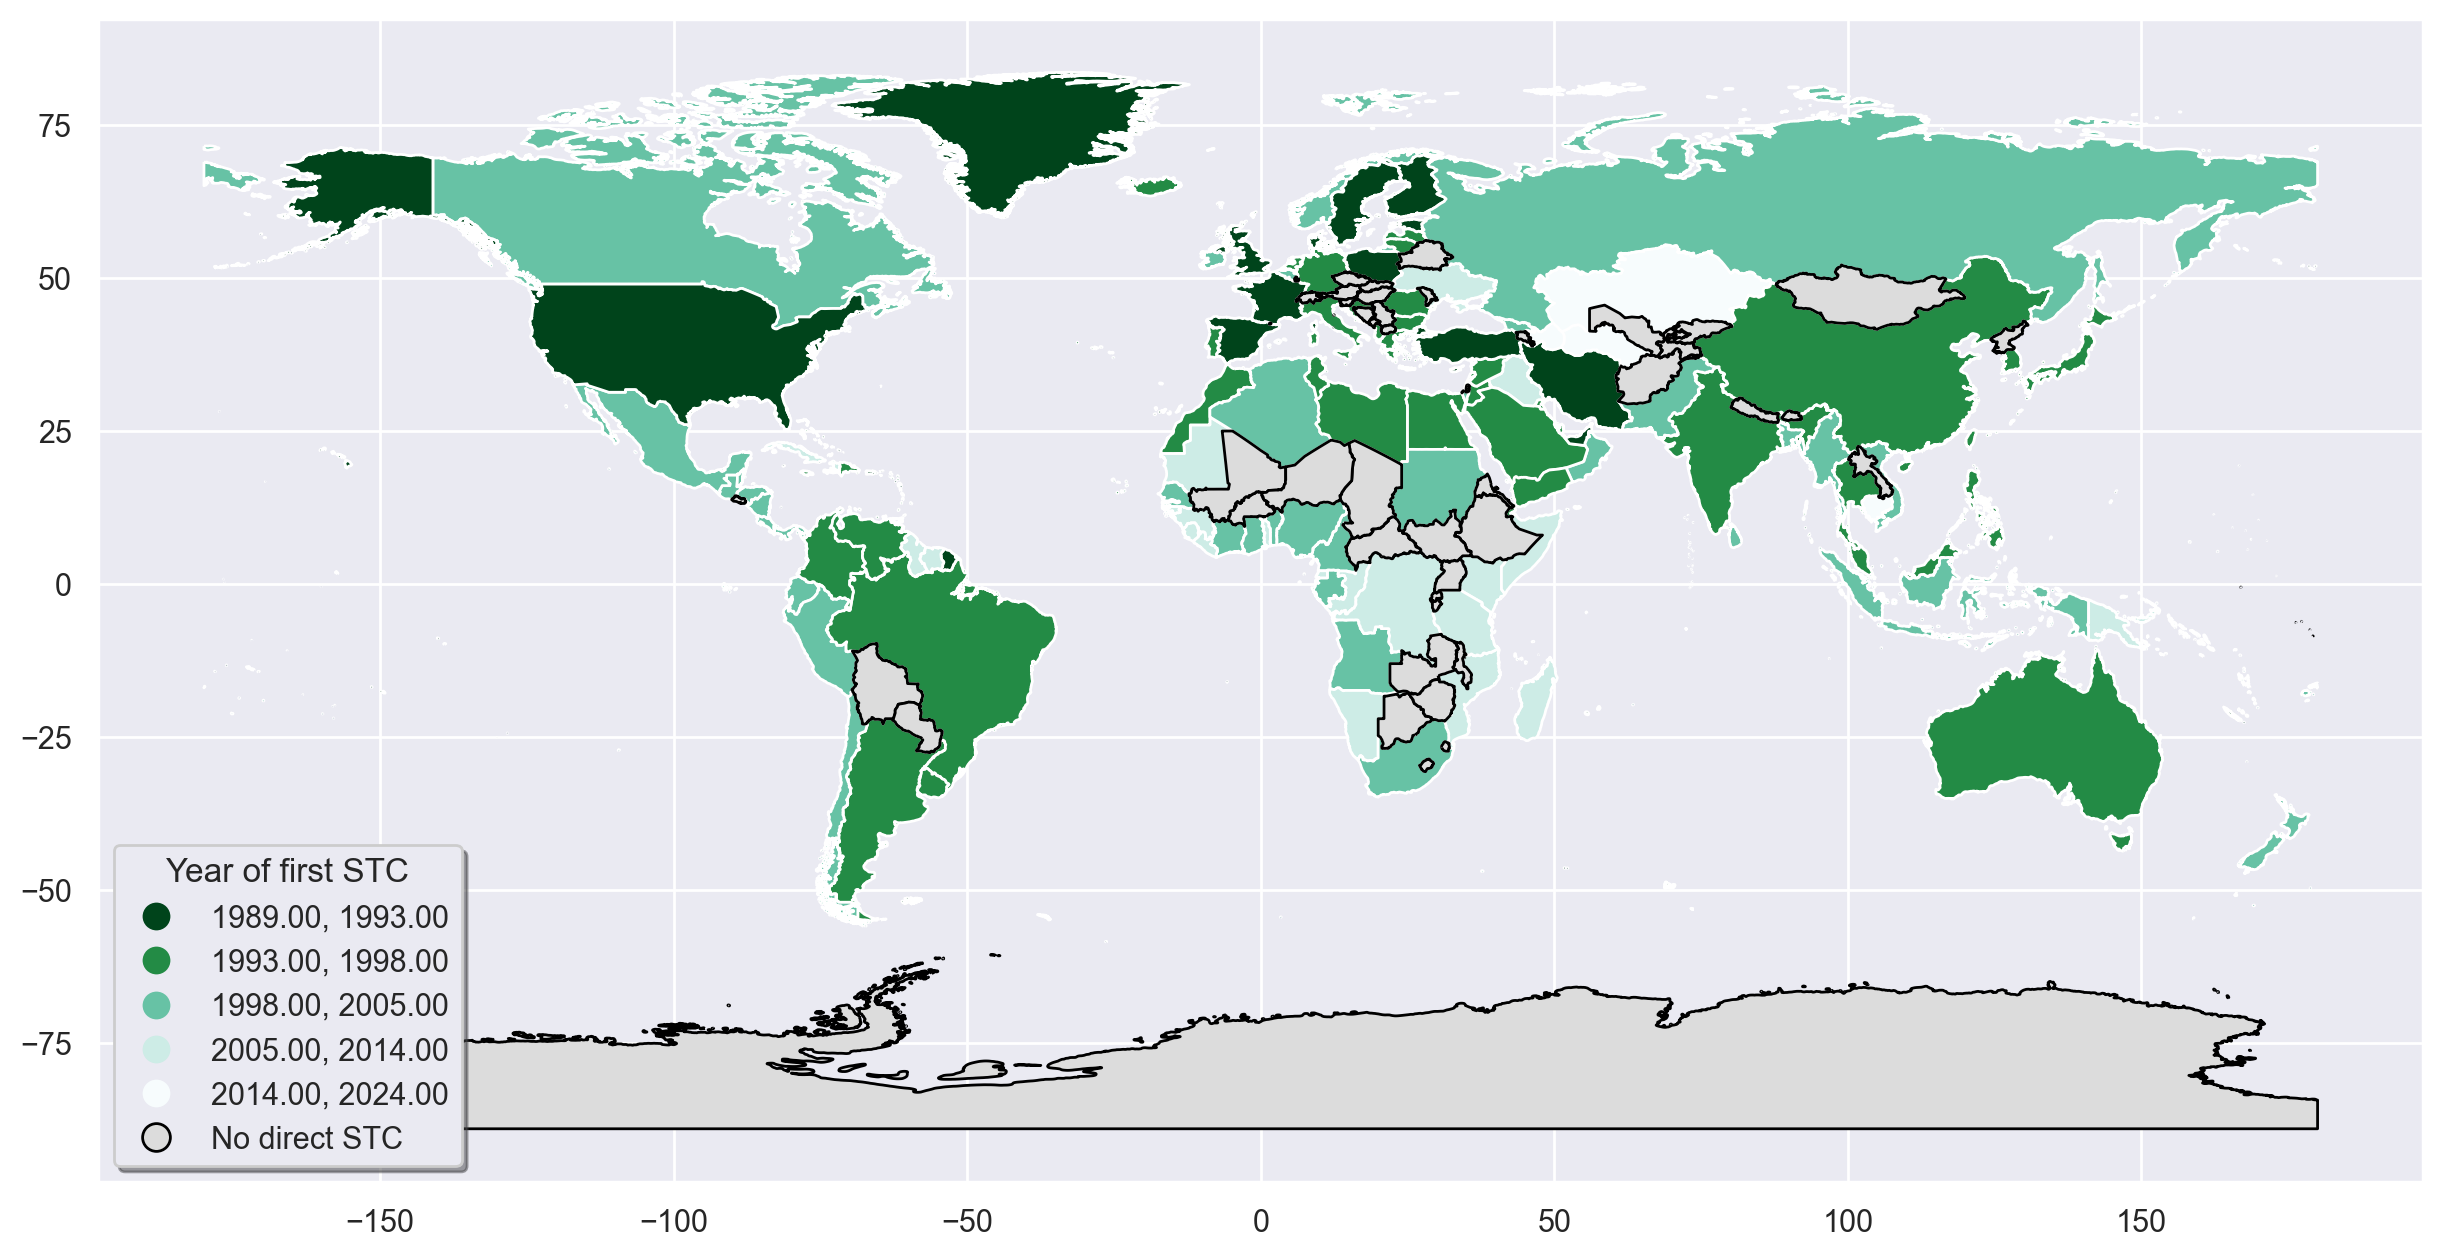

In [115]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf = gpd.GeoDataFrame(first_cable_merged, geometry='geometry')

orig_BuGn=plt.cm.get_cmap('BuGn')
orig_BuGn = truncate_colormap(orig_BuGn, 0.2, 1)
reversed_BuGn = orig_BuGn.reversed()
gdf.plot(gdf['first_cable_year'],  cmap=reversed_BuGn, missing_kwds={
"color": "gainsboro",
"edgecolor": "black",
"hatch": "",
"label": "No direct STC"
},legend=True, ax=ax,scheme='NaturalBreaks',k=5,legend_kwds={'loc': 'lower left','title': 'Year of first STC','shadow': True})
# ax.legend(title="图例", loc='lower left', ncol=1, shadow=True)


In [116]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landing_point_coor = pd.read_sql("select lp.cable_id, lp.cable_name, landingPoint_id, landingPoint_name, landingPoint_country as landingPoint_country_1, wc.continent as landingPoint_contient_1, cc.CapitalLongitude as lon1, cc.CapitalLatitude as lat1, merge_capacity, merge_length, merge_cost from landing_points lp left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id left join world_countries wc on lp.landingPoint_country = wc.name left join country_capital cc on wc.code = cc.CountryCode where CapitalLongitude is not null",con=con)
landing_point_coor

cable_id  \
0                            colombian-festoon   
1                            colombian-festoon   
2                            colombian-festoon   
3                            colombian-festoon   
4                            colombian-festoon   
...                                        ...   
2229  strategic-evolution-underwater-link-seul   
2230  strategic-evolution-underwater-link-seul   
2231                                    tannat   
2232                                    tannat   
2233                                    tannat   

                                      cable_name  \
0                              Colombian Festoon   
1                              Colombian Festoon   
2                              Colombian Festoon   
3                              Colombian Festoon   
4                              Colombian Festoon   
...                                          ...   
2229  Strategic Evolution Underwater Link (SEUL)   
2230  Strategic Evolution Underwater Link (SEUL)   
2231                                      Tannat   
2232                                      Tannat   
2233                                      Tannat   

                        landingPoint_id                   landingPoint_name  \
0                    cartagena-colombia                 Cartagena, Colombia   
1     parque-isla-de-salamanca-colombia  Parque Isla de Salamanca, Colombia   
2              puerto-colombia-colombia           Puerto Colombia, Colombia   
3                  santa-marta-colombia               Santa Marta, Colombia   
4                         tolu-colombia                      Tolu, Colombia   
...                                 ...                                 ...   
2229                       bomba-belize                       Bomba, Belize   
2230                   san-pedro-belize                   San Pedro, Belize   
2231              las-toninas-argentina              Las Toninas, Argentina   
2232                      santos-brazil                      Santos, Brazil   
2233                  maldonado-uruguay                  Maldonado, Uruguay   

     landingPoint_country_1 landingPoint_contient_1       lon1       lat1  \
0                  Colombia           South America -74.083333   4.600000   
1                  Colombia           South America -74.083333   4.600000   
2                  Colombia           South America -74.083333   4.600000   
3                  Colombia           South America -74.083333   4.600000   
4                  Colombia           South America -74.083333   4.600000   
...                     ...                     ...        ...        ...   
2229                 Belize           North America -88.766667  17.250000   
2230                 Belize           North America -88.766667  17.250000   
2231              Argentina           South America -58.666667 -34.583333   
2232                 Brazil           South America -47.916667 -15.783333   
2233                Uruguay           South America -56.166667 -34.850000   

      merge_capacity  merge_length  merge_cost  
0           0.078618         400.0      42.780  
1           0.078618         400.0      42.780  
2           0.078618         400.0      42.780  
3           0.078618         400.0      42.780  
4           0.078618         400.0      42.780  
...              ...           ...         ...  
2229       24.950555          24.0       0.625  
2230       24.950555          24.0       0.625  
2231       90.000000        2000.0      10.000  
2232       90.000000        2000.0      10.000  
2233       90.000000        2000.0      10.000  

[2234 rows x 11 columns]

In [117]:
def domestic_test(df):
    return df.drop_duplicates(subset='landingPoint_country_1')
temp = landing_point_coor.sort_values('lon1',ascending=True).groupby('cable_id',as_index=False).apply(domestic_test)
temp

cable_id              cable_name  \
0   412                  2africa                 2Africa   
    406                  2africa                 2Africa   
    384                  2africa                 2Africa   
    418                  2africa                 2Africa   
    392                  2africa                 2Africa   
...                          ...                     ...   
499 845   x-link-submarine-cable  X-Link Submarine Cable   
500 1127                  yellow                  Yellow   
    1126                  yellow                  Yellow   
501 1535                    zeus                    Zeus   
    1534                    zeus                    Zeus   

                    landingPoint_id            landingPoint_name  \
0   412               dakar-senegal               Dakar, Senegal   
    406         carcavelos-portugal         Carcavelos, Portugal   
    384         abidjan-cte-divoire       Abidjan, Cote D'Ivoire   
    418             barcelona-spain             Barcelona, Spain   
    392                 accra-ghana                 Accra, Ghana   
...                             ...                          ...   
499 845           georgetown-guyana           Georgetown, Guyana   
500 1127  bellport-ny-united-states  Bellport, NY, United States   
    1126        bude-united-kingdom         Bude, United Kingdom   
501 1535   lowestoft-united-kingdom    Lowestoft, United Kingdom   
    1534      zandvoort-netherlands       Zandvoort, Netherlands   

         landingPoint_country_1 landingPoint_contient_1       lon1       lat1  \
0   412                 Senegal                  Africa -17.633333  14.733333   
    406                Portugal                  Europe  -9.133333  38.716667   
    384           Cote D'Ivoire                  Africa  -5.266667   6.816667   
    418                   Spain                  Europe  -3.683333  40.400000   
    392                   Ghana                  Africa  -0.216667   5.550000   
...                         ...                     ...        ...        ...   
499 845                  Guyana           South America -58.150000   6.800000   
500 1127          United States           North America -77.000000  38.883333   
    1126         United Kingdom                  Europe  -0.083333  51.500000   
501 1535         United Kingdom                  Europe  -0.083333  51.500000   
    1534            Netherlands                  Europe   4.916667  52.350000   

          merge_capacity  merge_length  merge_cost  
0   412       140.458488  45000.000000     925.000  
    406       140.458488  45000.000000     925.000  
    384       140.458488  45000.000000     925.000  
    418       140.458488  45000.000000     925.000  
    392       140.458488  45000.000000     925.000  
...                  ...           ...         ...  
499 845        44.384991    775.000000      19.375  
500 1127        0.186533   7001.000000     207.810  
    1126        0.186533   7001.000000     207.810  
501 1535     4000.000000    341.810776      41.330  
    1534     4000.000000    341.810776      41.330  

[1308 rows x 11 columns]

In [118]:
def shift_lonlat(df):
    df['lon2'] = df['lon1'].shift()
    df['lat2'] = df['lat1'].shift()
    df['landingPoint_country_2'] = df['landingPoint_country_1'].shift()
    df['landingPoint_contient_2'] = df['landingPoint_contient_1'].shift()
    return df

In [119]:

country_cable = pd.DataFrame()
for x in list(temp.groupby('cable_id')):
    if x[1].shape[0]!=1: # international cable
        country_cable = country_cable.append(shift_lonlat(x[1]),ignore_index=True)
    # else:
    #     # domestic cable
    #     print()

# list(temp.groupby('cable_id'))[0][1]


In [120]:
dest = {}
country_cable = country_cable.dropna()
# for row in country_cable.shape[0]:
#     if (country_cable.iloc[row, 'landingPoint_country_1']):
#         print(1)
#         if ()
#     elif (country_cable.iloc[row, 'landingPoint_country_2'] in dest):
#         print(2)
#     else:
#         dest = dest.append({'country_1': country_cable.iloc[row,'landingPoint_country_1'], 'country_2': country_cable.iloc[row,'landingPoint_country_2'], 'lon1': country_cable.iloc[row,'lon1'], 'lat1': country_cable.iloc[row,'lat1'], 'lon2': country_cable.iloc[row,'lon2'], 'lat2': country_cable.iloc[row,'lat2'],  'merge_cost': country_cable.iloc[row,'merge_cost'], 'merge_capacity': country_cable.iloc[row,'merge_capacity'], 'merge_length': country_cable.iloc[row,'merge_length'],},ignore_index=True)
country_cable.to_csv('/Users/dijiongyuequ/Downloads/country_length_capacity_cost.csv')

In [121]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    country_length_capcity_cost = pd.read_sql("select landingPoint_country_1, landingPoint_contient_1, lon1, lat1, landingPoint_country_2, landingPoint_contient_2, lon2, lat2, count(*)            as number_of_line, sum(merge_capacity) as total_capacity, avg(merge_length)   as avg_length, avg(merge_cost)     as avg_cost from country_length_capacity_cost group by landingPoint_country_1, landingPoint_country_2",con=con)
country_length_capcity_cost


landingPoint_country_1 landingPoint_contient_1        lon1       lat1  \
0                  Albania                  Europe   19.816667  41.316667   
1                  Albania                  Europe   19.816667  41.316667   
2                  Algeria                  Africa    3.050000  36.750000   
3                  Algeria                  Africa    3.050000  36.750000   
4           American Samoa                 Oceania -170.700000 -14.266667   
..                     ...                     ...         ...        ...   
391  Virgin Islands (U.K.)           North America  -64.616667  18.416667   
392  Virgin Islands (U.S.)           North America  -64.933333  18.350000   
393  Virgin Islands (U.S.)           North America  -64.933333  18.350000   
394                  Yemen                    Asia   44.200000  15.350000   
395                  Yemen                    Asia   44.200000  15.350000   

    landingPoint_country_2 landingPoint_contient_2        lon2       lat2  \
0                  Croatia                  Europe   16.000000  45.800000   
1                    Italy                  Europe   12.483333  41.900000   
2                   France                  Europe    2.333333  48.866667   
3                    Spain                  Europe   -3.683333  40.400000   
4                    Samoa                 Oceania -171.766667 -13.816667   
..                     ...                     ...         ...        ...   
391     Dominican Republic           North America  -69.900000  18.466667   
392     Dominican Republic           North America  -69.900000  18.466667   
393          United States           North America  -77.000000  38.883333   
394               Djibouti                  Africa   43.150000  11.583333   
395                  Sudan                  Africa   32.533333  15.600000   

     number_of_line  total_capacity  avg_length   avg_cost  
0                 1        0.000622      440.00   13.40000  
1                 1        0.002500      240.00   10.00000  
2                 4      510.807308     8423.50  291.40750  
3                 2       40.160000      541.00   22.30000  
4                 1        2.491475      250.00    6.25000  
..              ...             ...         ...        ...  
391               1        2.500000     1750.00   35.00000  
392               1      140.458488      670.00   16.75000  
393               1        0.078618      183.00    4.57500  
394               4      290.740053    13817.25  397.37625  
395               1        2.560000    10300.00  900.00000  

[396 rows x 12 columns]

In [122]:
gdf = gpd.GeoDataFrame(country_length_capcity_cost)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)

# gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
# gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
# gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']
# gdf['segment_cost'] = gdf['cable_cost']/gdf['cable_length'] * gdf['length_from_previous']

gdf['inverse_length'] = 1/gdf['avg_length']
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column

gdf.drop(['fr_point','to_point'], axis=1, inplace=True)

gdf

landingPoint_country_1 landingPoint_contient_1        lon1       lat1  \
0                  Albania                  Europe   19.816667  41.316667   
1                  Albania                  Europe   19.816667  41.316667   
2                  Algeria                  Africa    3.050000  36.750000   
3                  Algeria                  Africa    3.050000  36.750000   
4           American Samoa                 Oceania -170.700000 -14.266667   
..                     ...                     ...         ...        ...   
391  Virgin Islands (U.K.)           North America  -64.616667  18.416667   
392  Virgin Islands (U.S.)           North America  -64.933333  18.350000   
393  Virgin Islands (U.S.)           North America  -64.933333  18.350000   
394                  Yemen                    Asia   44.200000  15.350000   
395                  Yemen                    Asia   44.200000  15.350000   

    landingPoint_country_2 landingPoint_contient_2        lon2       lat2  \
0                  Croatia                  Europe   16.000000  45.800000   
1                    Italy                  Europe   12.483333  41.900000   
2                   France                  Europe    2.333333  48.866667   
3                    Spain                  Europe   -3.683333  40.400000   
4                    Samoa                 Oceania -171.766667 -13.816667   
..                     ...                     ...         ...        ...   
391     Dominican Republic           North America  -69.900000  18.466667   
392     Dominican Republic           North America  -69.900000  18.466667   
393          United States           North America  -77.000000  38.883333   
394               Djibouti                  Africa   43.150000  11.583333   
395                  Sudan                  Africa   32.533333  15.600000   

     number_of_line  total_capacity  avg_length   avg_cost       fr_id  \
0                 1        0.000622      440.00   13.40000   6113334.0   
1                 1        0.002500      240.00   10.00000   6113334.0   
2                 4      510.807308     8423.50  291.40750   3980000.0   
3                 2       40.160000      541.00   22.30000   3980000.0   
4                 1        2.491475      250.00    6.25000 -18496667.0   
..              ...             ...         ...        ...         ...   
391               1        2.500000     1750.00   35.00000  -4620000.0   
392               1      140.458488      670.00   16.75000  -4658333.0   
393               1        0.078618      183.00    4.57500  -4658333.0   
394               4      290.740053    13817.25  397.37625   5955000.0   
395               1        2.560000    10300.00  900.00000   5955000.0   

          to_id  inverse_length  \
0     6180000.0        0.002273   
1     5438333.0        0.004167   
2     5120000.0        0.000119   
3     3671667.0        0.001848   
4   -18558334.0        0.004000   
..          ...             ...   
391  -5143333.0        0.000571   
392  -5143333.0        0.001493   
393  -3811667.0        0.005464   
394   5473333.0        0.000072   
395   4813333.0        0.000097   

                                                  line  
0    LINESTRING (19.816667 41.31666666666667, 16 45.8)  
1    LINESTRING (19.816667 41.31666666666667, 12.48...  
2    LINESTRING (3.05 36.75, 2.333333 48.8666666666...  
3              LINESTRING (3.05 36.75, -3.683333 40.4)  
4    LINESTRING (-170.7 -14.266666666666667, -171.7...  
..                                                 ...  
391  LINESTRING (-64.616667 18.416666666666668, -69...  
392  LINESTRING (-64.933333 18.35, -69.9 18.4666666...  
393       LINESTRING (-64.933333 18.35, -77 38.883333)  
394  LINESTRING (44.2 15.35, 43.15 11.583333333333334)  
395            LINESTRING (44.2 15.35, 32.533333 15.6)  

[396 rows x 16 columns]

In [123]:
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
worldMap=worldMap[worldMap['continent'] != 'Antarctica']
worldMap.loc[worldMap['name'] == 'France', 'iso_a3'] = 'FRA'
worldMap.loc[worldMap['name'] == 'Norway', 'iso_a3'] = 'NOR'
worldMap.loc[worldMap['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
worldMap.loc[worldMap['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
worldMap.loc[worldMap['name'] == 'Kosovo', 'iso_a3'] = 'RKS'
worldMap

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    RKS     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[176 rows x 6 columns]

<AxesSubplot:>

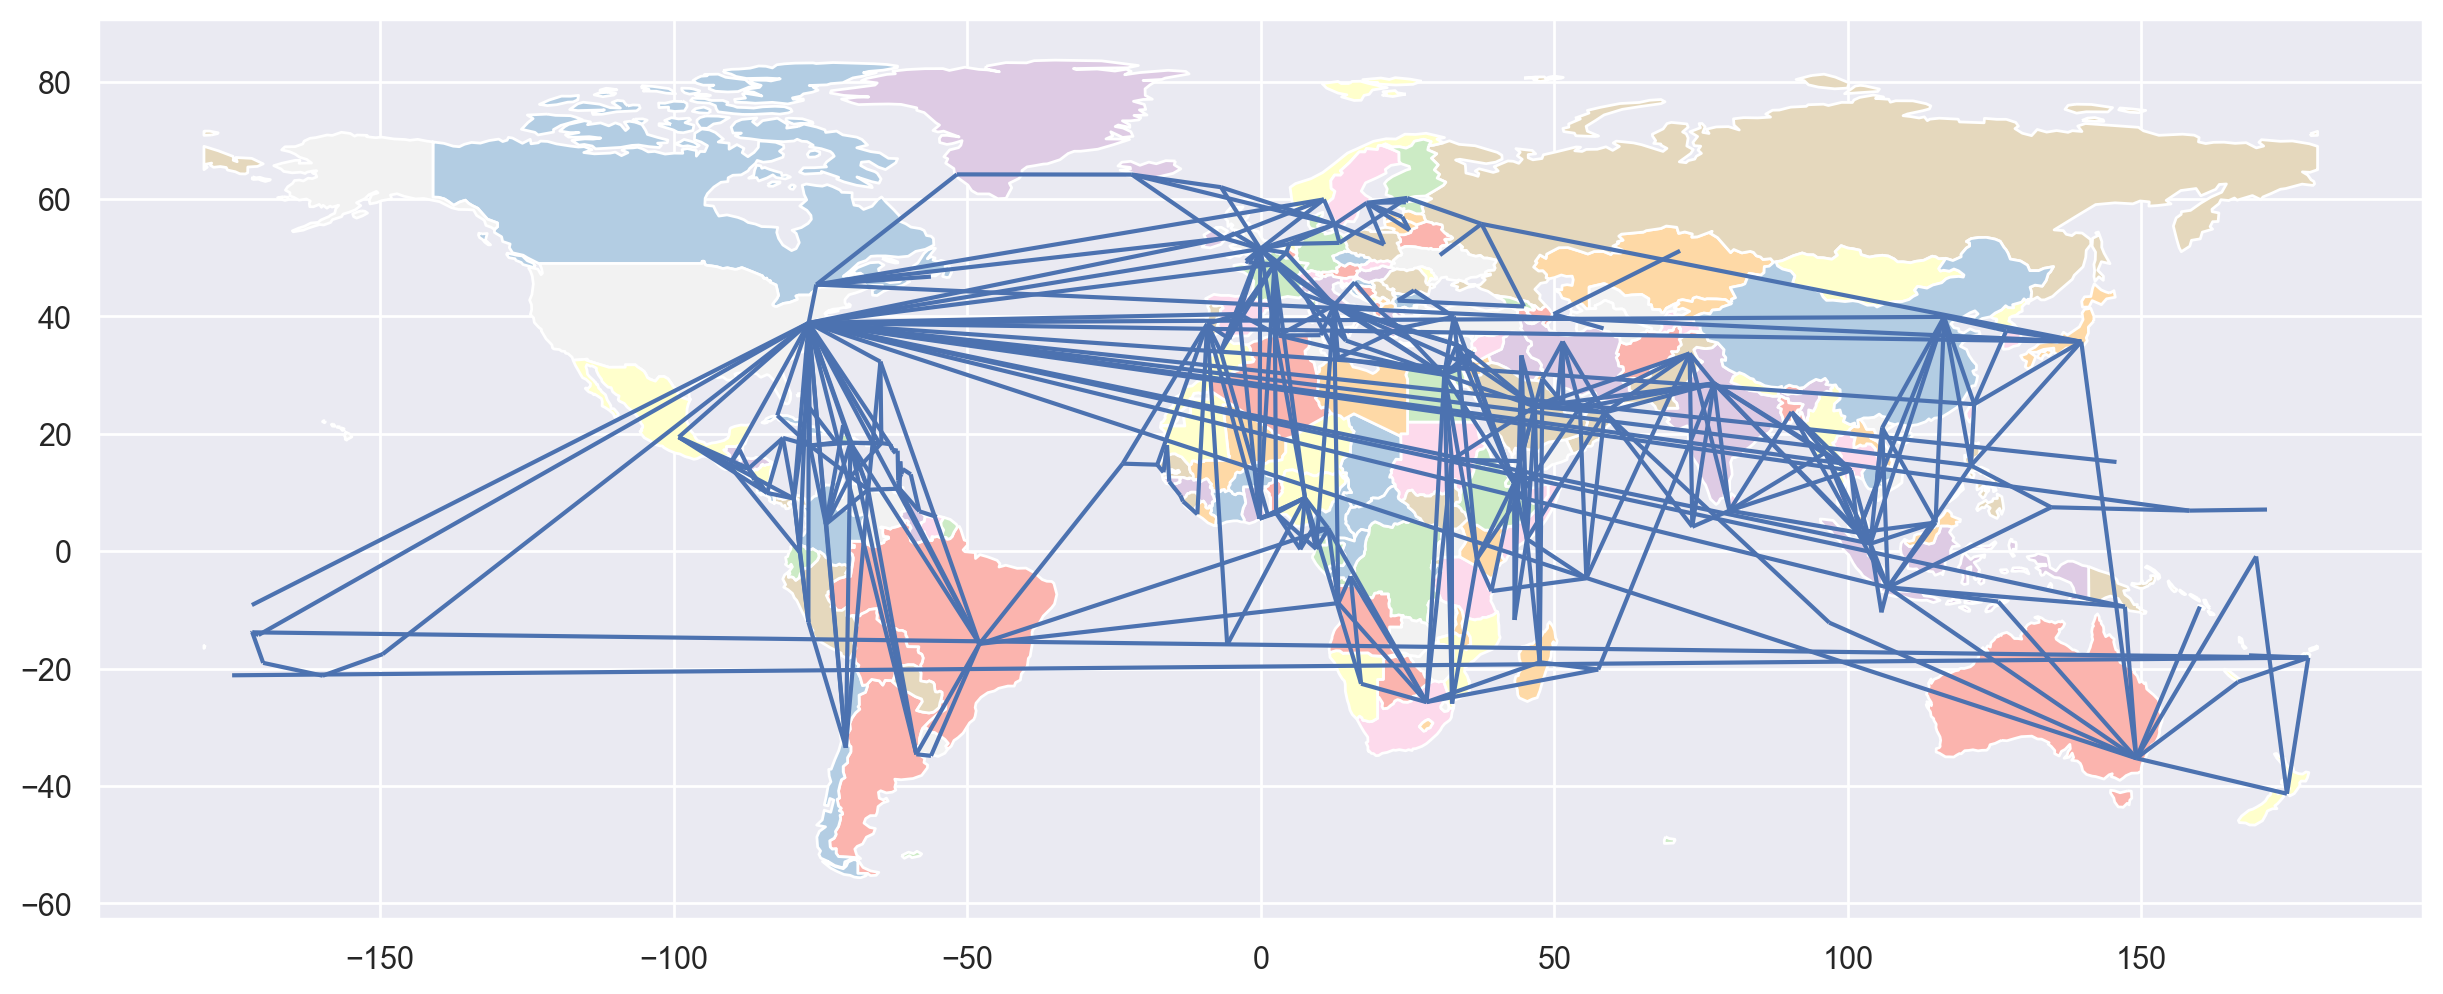

In [124]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
worldMap.plot(column = 'name', ax=ax, cmap = 'Pastel1')
gdf.plot(legend=True,legend_kwds={'label': "Travel time (min)"},ax=ax)

# leg1 = ax.legend(loc='upper right')
# ax.add_artist(leg1)


/opt/homebrew/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


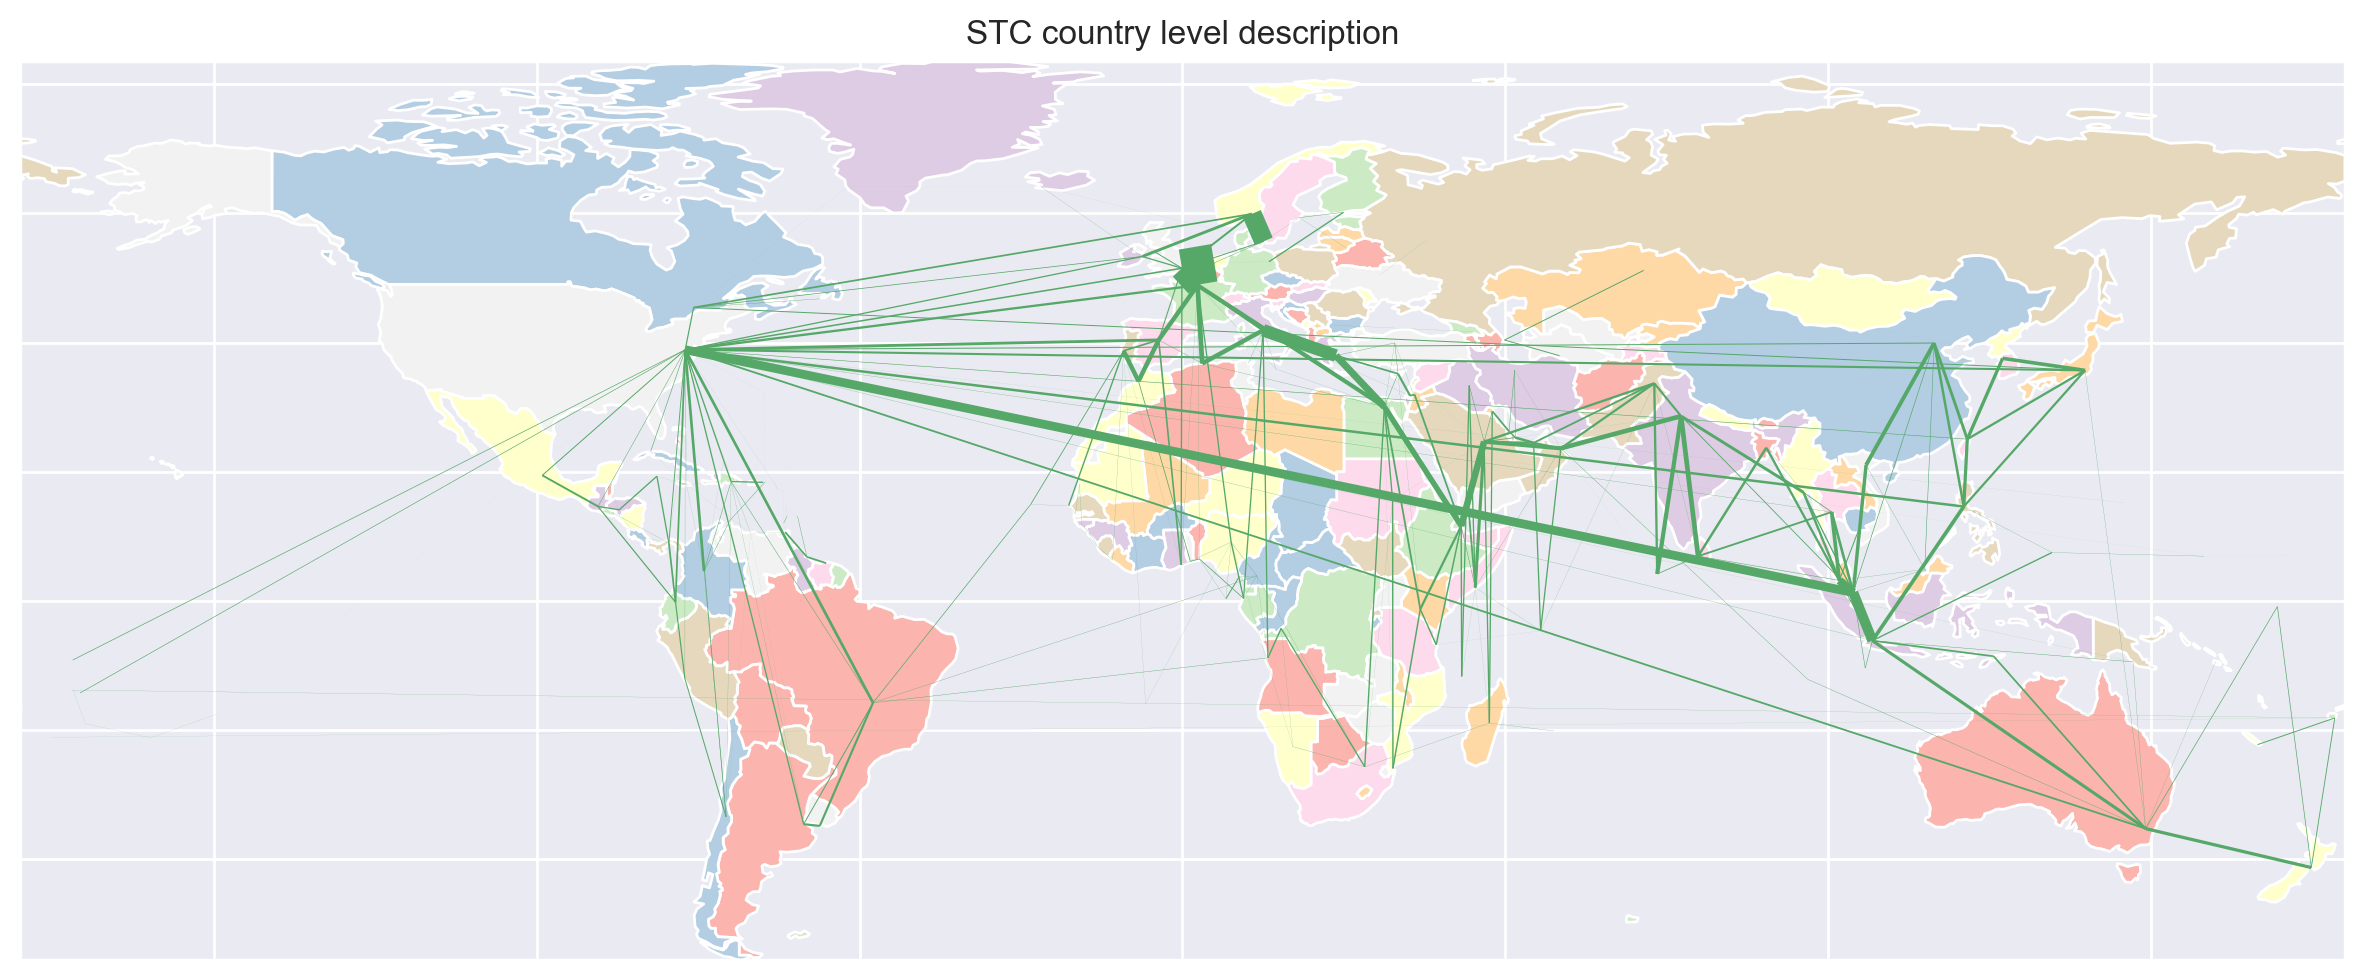

In [141]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'name', ax=ax, cmap = 'Pastel1')
gdf.plot(column=gdf['total_capacity'],linewidth= gdf['total_capacity']/300, color = 'g',ax=ax)

plt.title('STC country level description')
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
# cmap='BuGn',)

Text(0.5, 1.0, 'High level data description')

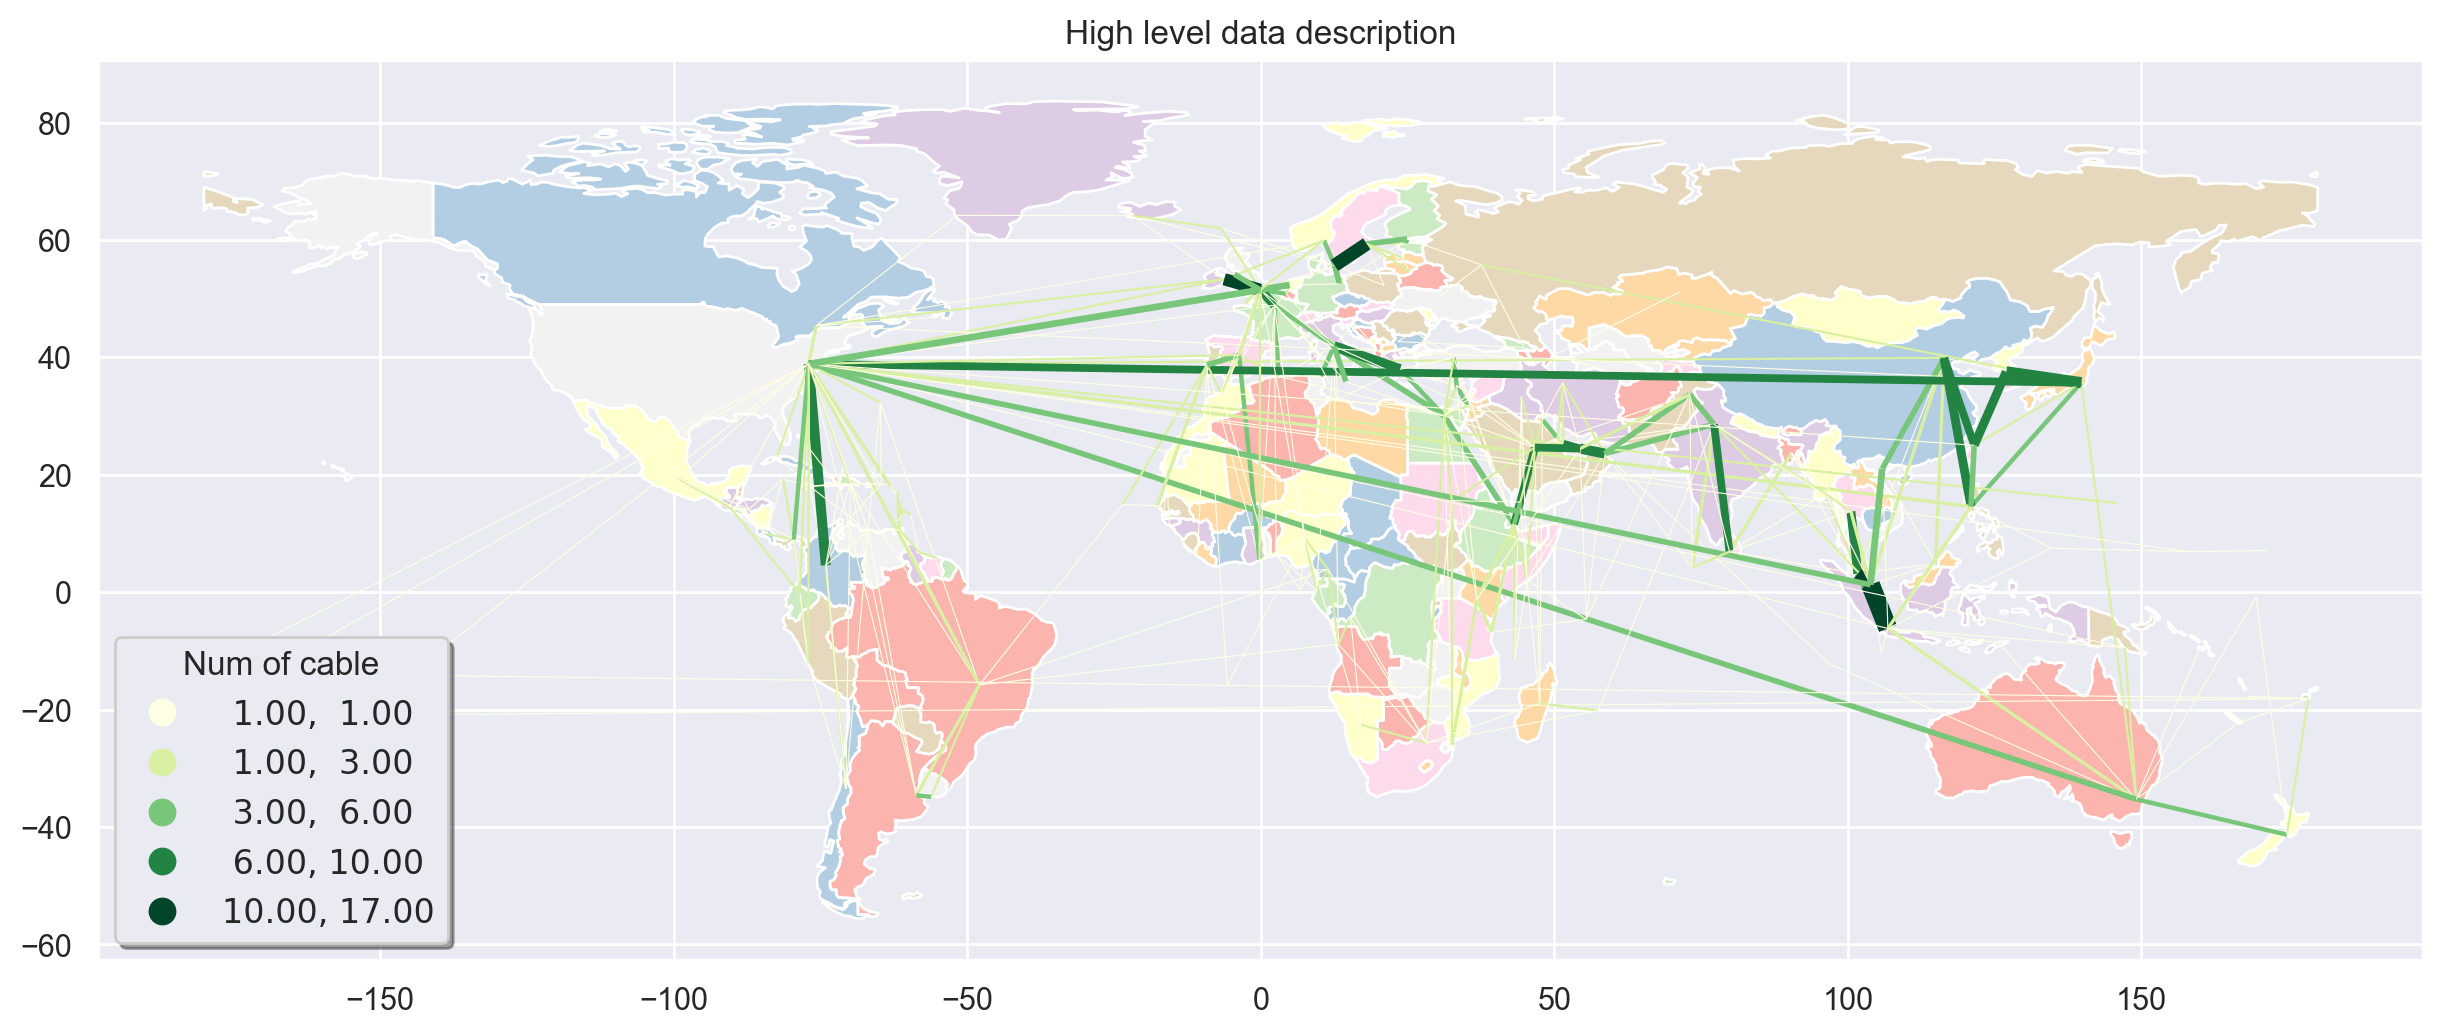

In [126]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'name', ax=ax, cmap = 'Pastel1')
# gdf.plot(column='number_of_line', ax=ax,legend=True, aspect=1,linewidth= gdf['number_of_line']/2.5, color = 'g')
gdf.plot(column='number_of_line', ax=ax,legend=True, aspect=1,linewidth= gdf['number_of_line']/2.5, cmap = 'YlGn',scheme='NaturalBreaks',k=5,legend_kwds={ 'loc': 'lower left', 'title': 'Num of cable','prop':'small', 'shadow': True})
# red_patch = mpatches.Patch(color='g', label='Country wide connection')
# ax.legend(handles=[red_patch])
plt.title("High level data description")
# worldMap.plot(column='continent', ax=ax, legend=True,cmap='Set2',aspect=1,legend_kwds={'loc': 'lower left'})

# cmap='BuGn',)

In [127]:
gdf.sort_values('number_of_line',ascending=False).head(10)[['landingPoint_country_1','landingPoint_contient_1','landingPoint_country_2','landingPoint_contient_2','number_of_line']]

landingPoint_country_1 landingPoint_contient_1 landingPoint_country_2  \
158              Indonesia                    Asia              Singapore   
333                 Sweden                  Europe                Denmark   
307              Singapore                    Asia               Malaysia   
365         United Kingdom                  Europe                Ireland   
184                  Japan                    Asia            South Korea   
64                Colombia           South America          United States   
135                 Greece                  Europe                  Italy   
255                   Oman                    Asia   United Arab Emirates   
120                 France                  Europe         United Kingdom   
269            Philippines                    Asia                  China   

    landingPoint_contient_2  number_of_line  
158                    Asia              17  
333                  Europe              12  
307                    Asia              11  
365                  Europe              11  
184                    Asia              10  
64            North America               9  
135                  Europe               9  
255                    Asia               9  
120                  Europe               8  
269                    Asia               8

In [128]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   landingPoint_country_1   396 non-null    object  
 1   landingPoint_contient_1  396 non-null    object  
 2   lon1                     396 non-null    float64 
 3   lat1                     396 non-null    float64 
 4   landingPoint_country_2   396 non-null    object  
 5   landingPoint_contient_2  396 non-null    object  
 6   lon2                     396 non-null    float64 
 7   lat2                     396 non-null    float64 
 8   number_of_line           396 non-null    int64   
 9   total_capacity           396 non-null    float64 
 10  avg_length               396 non-null    float64 
 11  avg_cost                 396 non-null    float64 
 12  fr_id                    396 non-null    float64 
 13  to_id                    396 non-null    float64 
 14  in

In [129]:
len((set (gdf['landingPoint_country_1'].unique())).union(set (gdf['landingPoint_country_2'].unique())))

173

In [130]:
worldMap

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    RKS     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[176 rows x 6 columns]

<AxesSubplot:>

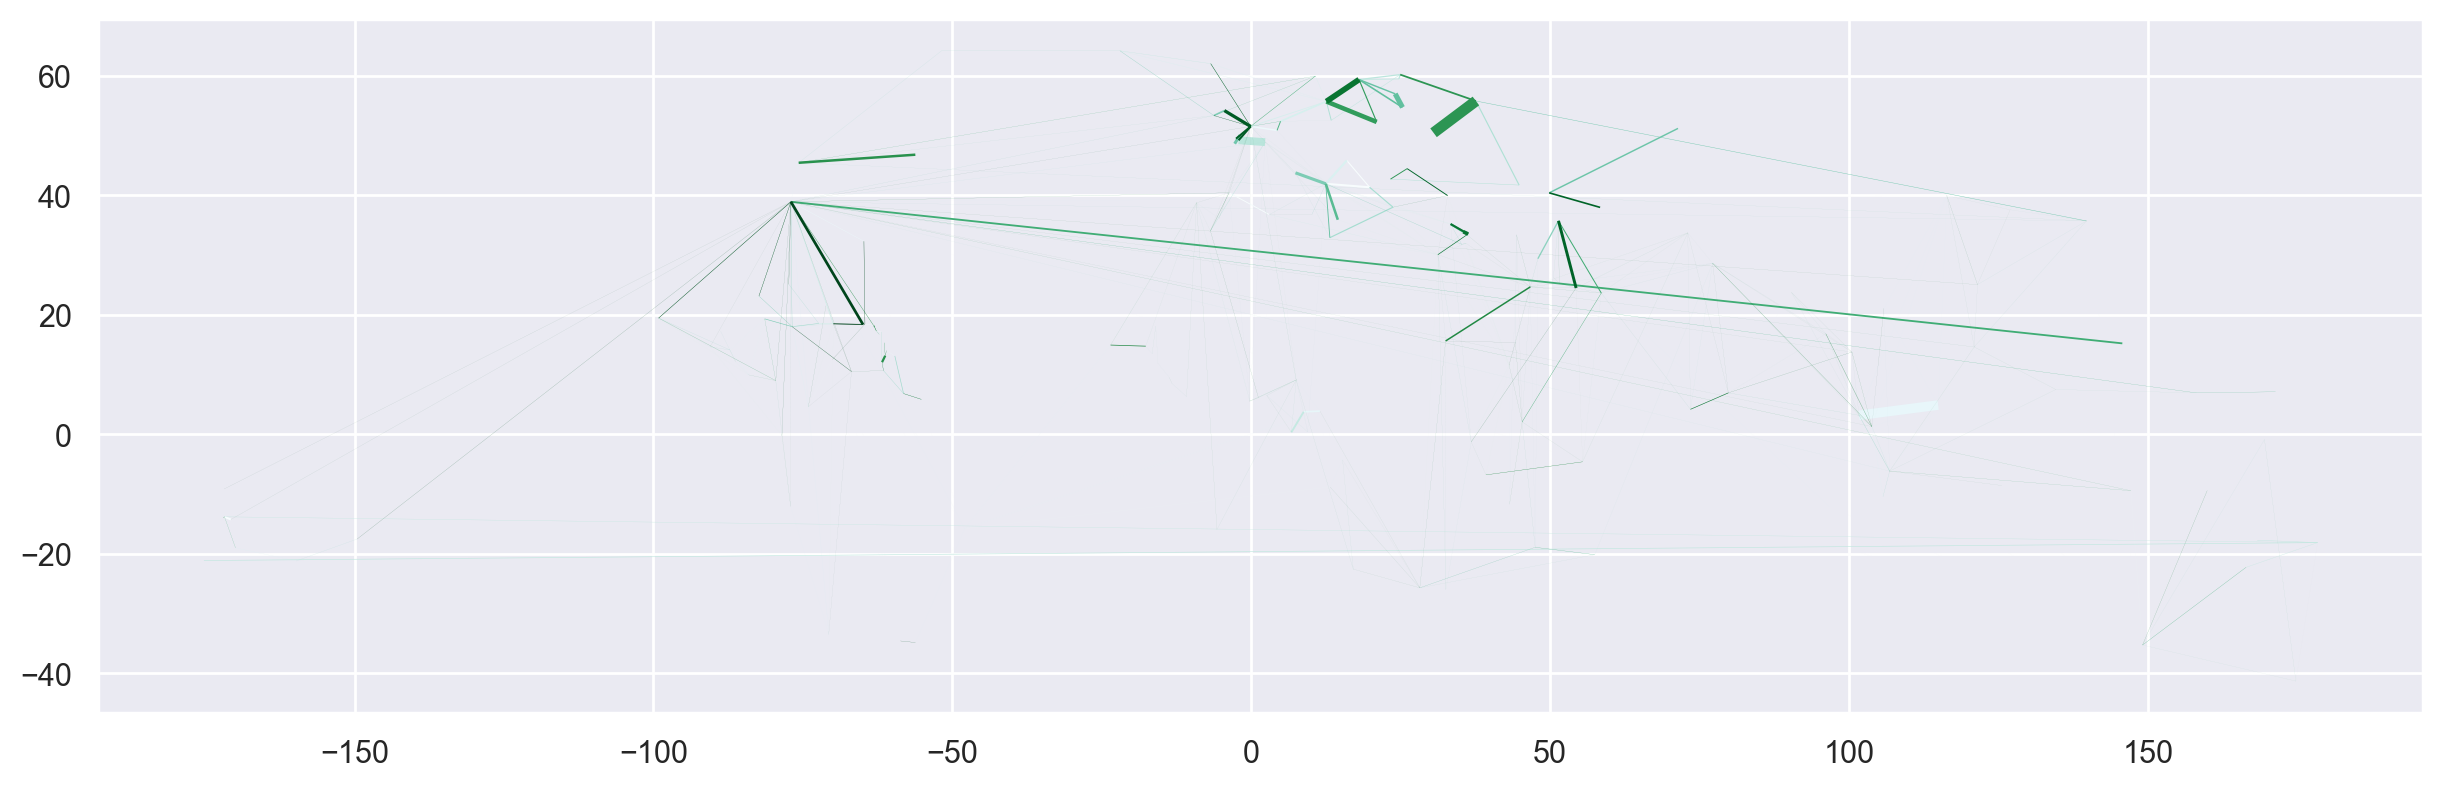

In [131]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
gdf.plot(ax=ax, linewidth= gdf['inverse_length']*180,cmap='BuGn')

<AxesSubplot:>

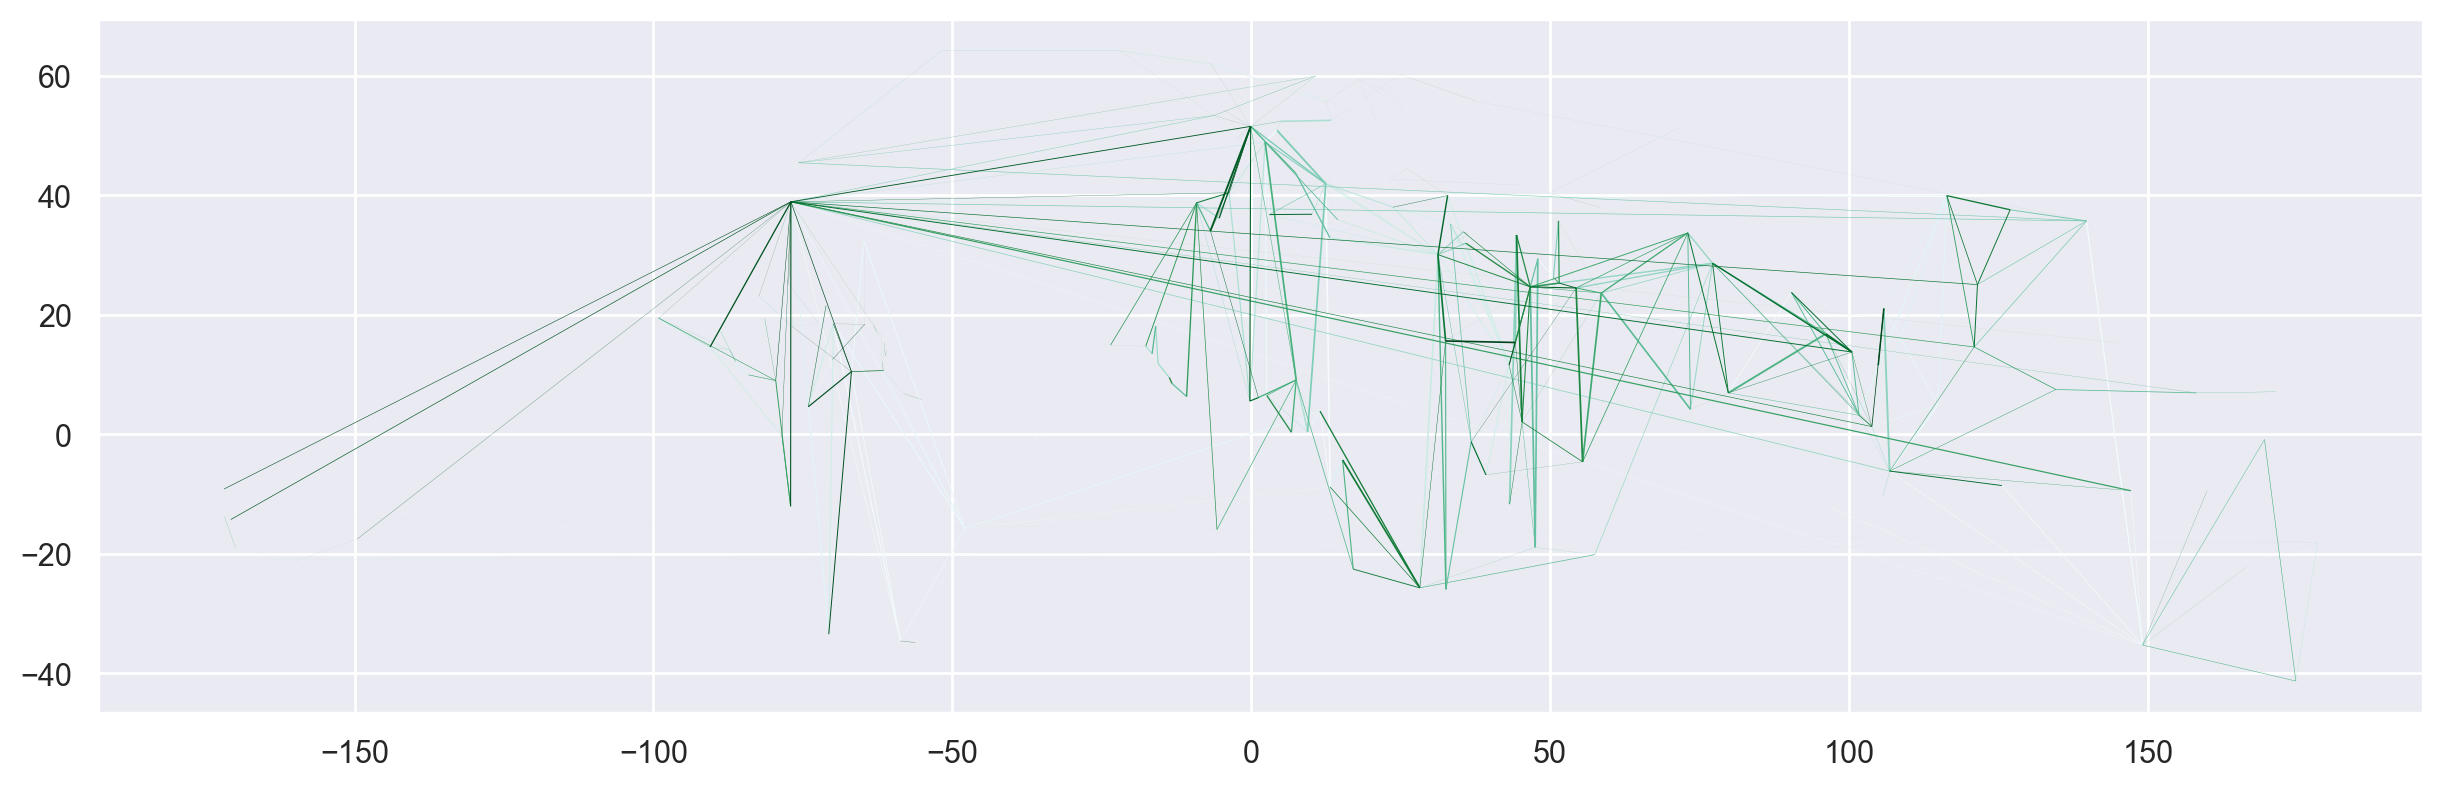

In [132]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
gdf.plot(ax=ax, linewidth= gdf['avg_cost']/1500,cmap='BuGn',)

In [133]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_cable_node_count = pd.read_sql("select count(landingPoint_name) as node_count, landingPoint_id, landingPoint_name, landingPoint_country, landingPoint_longitude, landingPoint_latitude from landing_points group by landingPoint_name",con=con)
landingPoint_cable_node_count.sort_values(by='node_count')


node_count             landingPoint_id            landingPoint_name  \
0              1           aasiaat-greenland           Aasiaat, Greenland   
807            1         novorossiysk-russia         Novorossiysk, Russia   
808            1  nuku-hiva-french-polynesia  Nuku Hiva, French Polynesia   
812            1                 nyali-kenya                 Nyali, Kenya   
813            1               nybor-denmark               Nybor, Denmark   
...          ...                         ...                          ...   
694           13            marseille-france            Marseille, France   
488           13         jeddah-saudi-arabia         Jeddah, Saudi Arabia   
1235          13              tuas-singapore              Tuas, Singapore   
120           14             batam-indonesia             Batam, Indonesia   
754           16                mumbai-india                Mumbai, India   

     landingPoint_country  landingPoint_longitude  landingPoint_latitude  
0               Greenland              -52.859117              68.706972  
807                Russia               37.772801              44.723631  
808      French Polynesia             -140.142096              -8.860488  
812                 Kenya               39.700046              -4.050504  
813               Denmark               10.799481              55.324102  
...                   ...                     ...                    ...  
694                France                5.372507              43.293579  
488          Saudi Arabia               39.182863              21.481547  
1235            Singapore              103.646210               1.338646  
120             Indonesia              104.016637               1.066798  
754                 India               72.875866              19.076080  

[1335 rows x 6 columns]

In [134]:
import seaborn as sns



/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_41758/2607129917.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(['0-1','1-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140', '141-150'])


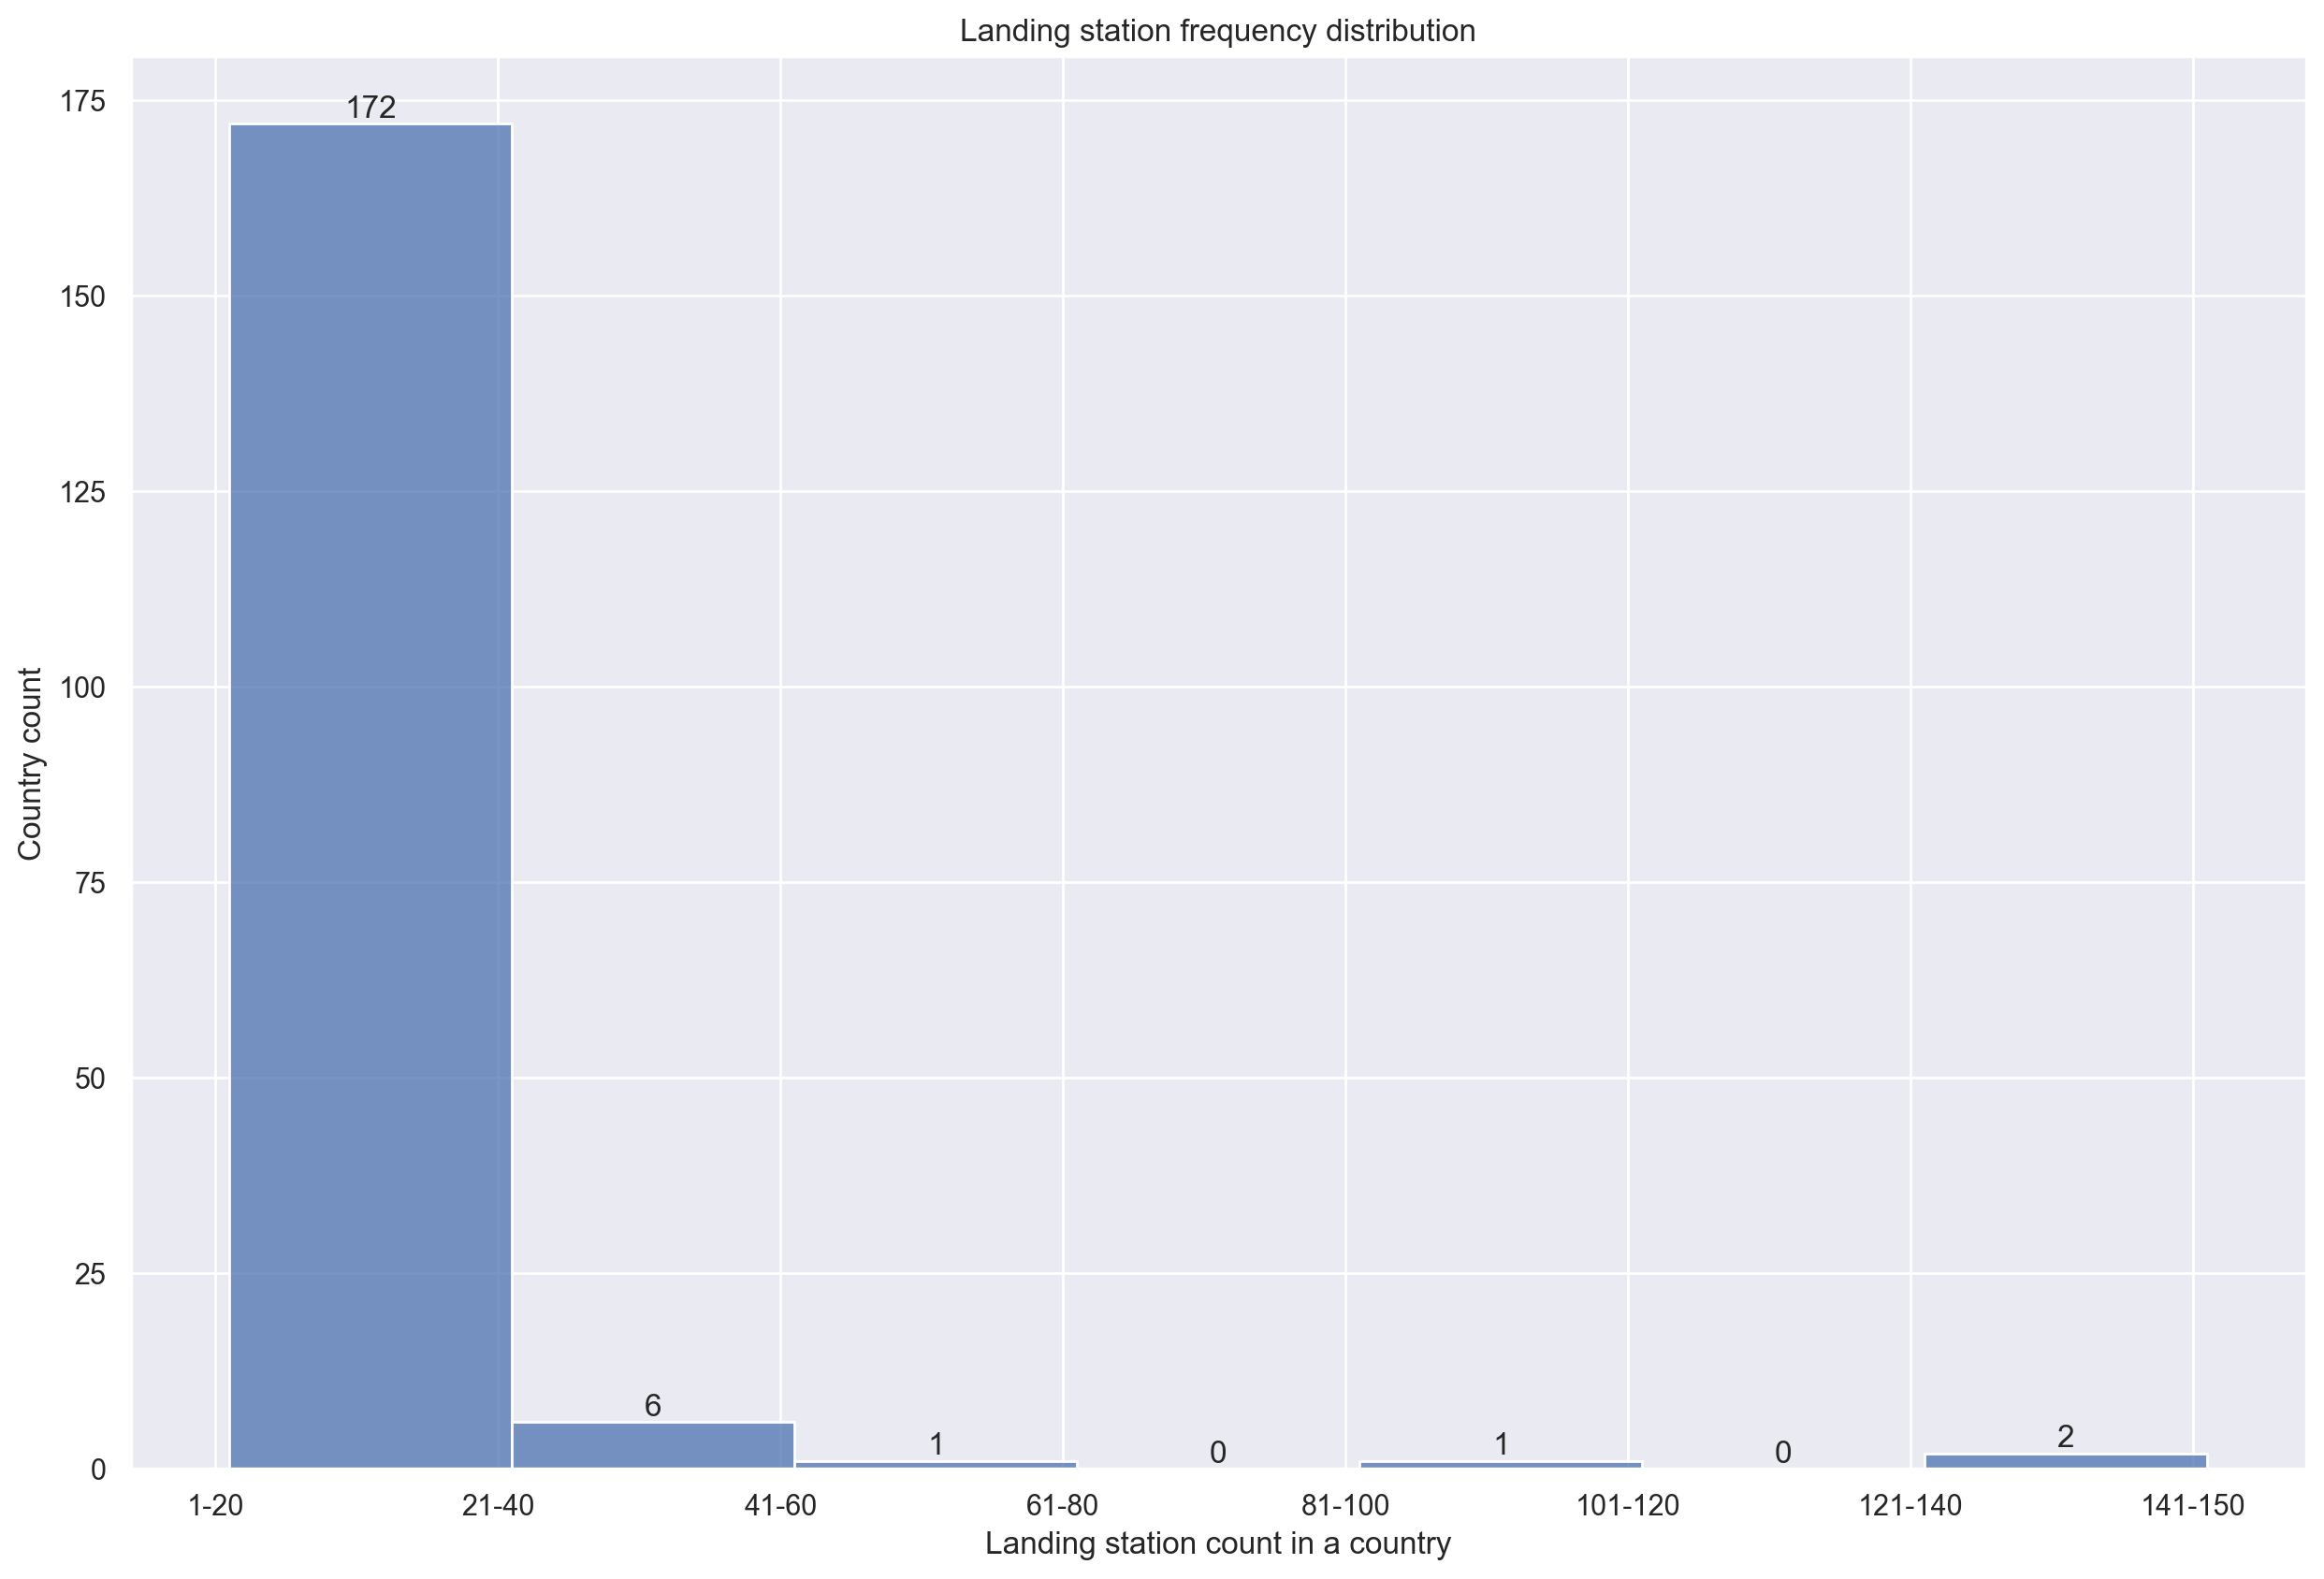

In [162]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_countByCountry = pd.read_sql("select count(distinct landingPoint_id) as landingPointCount from landing_points_with_countryCode group by landingPoint_country",con=con)

sns.set()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

h = sns.histplot(landingPoint_countByCountry['landingPointCount'], bins=range(1,150,20),ax=ax)
plt.xlabel('Landing station count in a country')
plt.ylabel('Country count')
plt.title('Landing station frequency distribution')

ax.bar_label(ax.containers[0])
h.set_xticklabels(['0-1','1-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140', '141-150'])

plt.show()


/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_41758/1445313066.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(['0-1','1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15-16'])


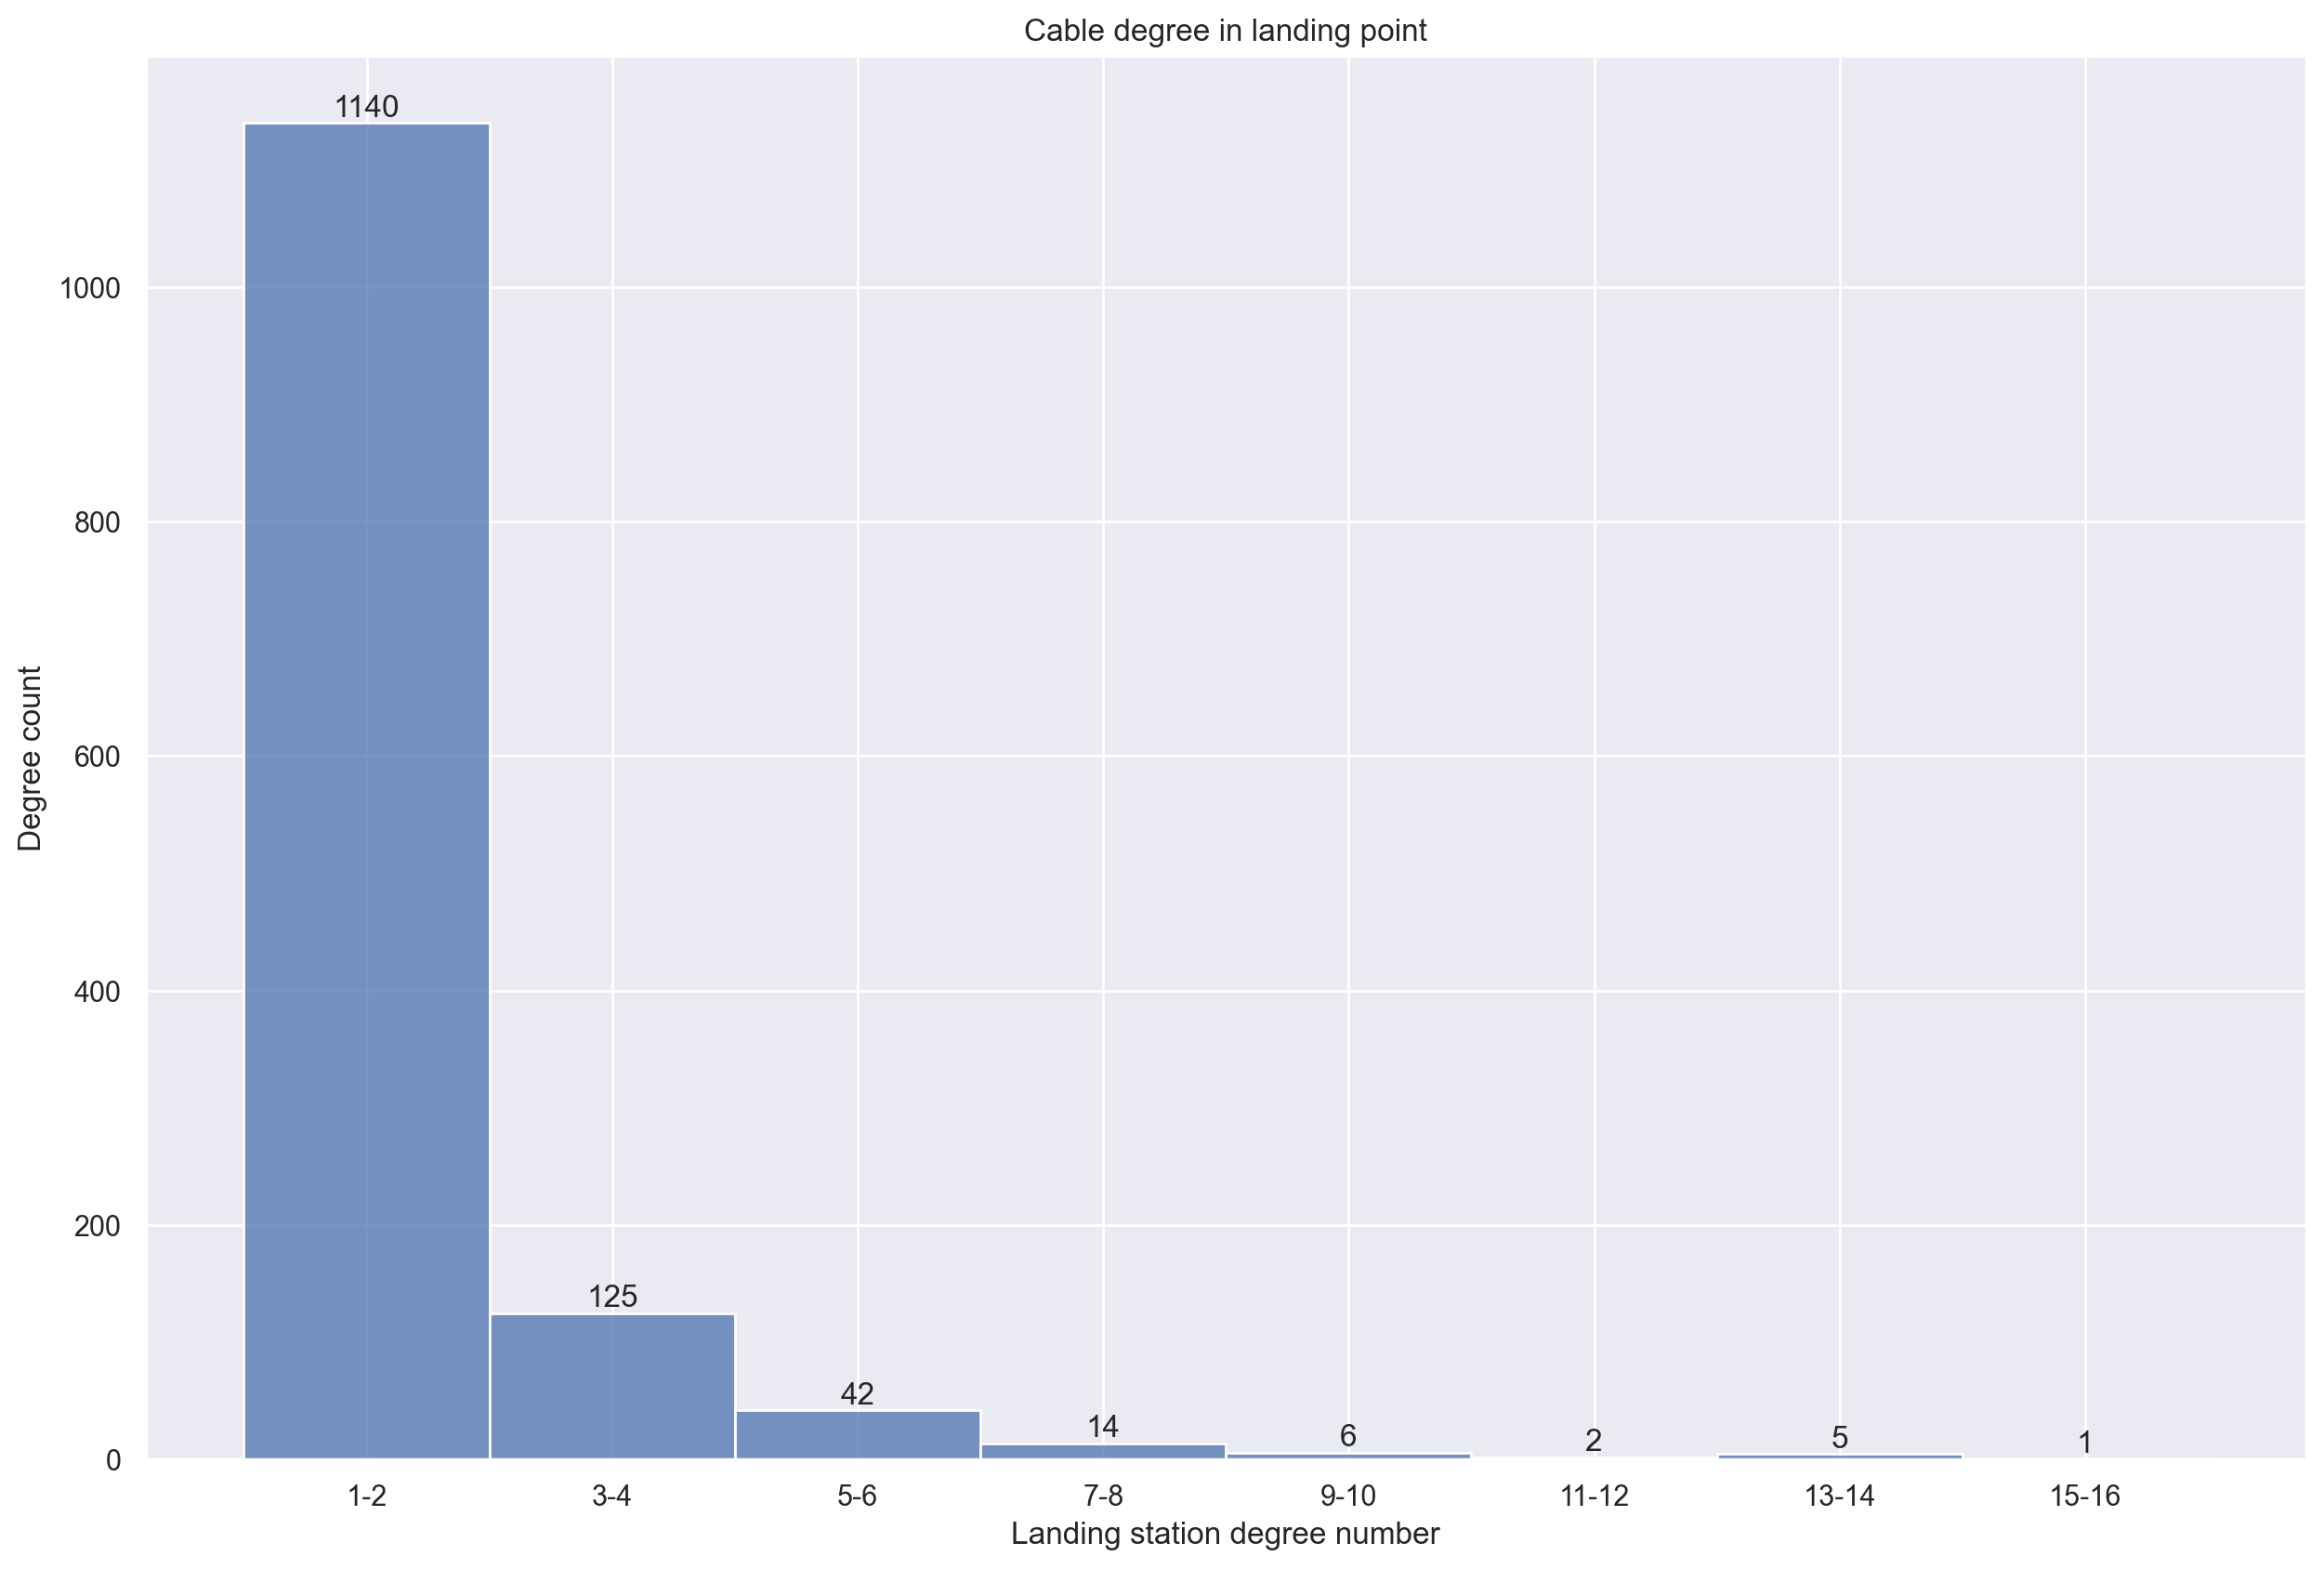

In [160]:
sns.set()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

h = sns.histplot(landingPoint_cable_node_count['node_count'], bins=range(1,19,2),ax=ax)
plt.xlabel('Landing station degree number')
plt.ylabel('Degree count')
plt.title('Cable degree in landing point')

ax.bar_label(ax.containers[0])
# h.set_xticks([1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5, 17.5])
h.set_xticklabels(['0-1','1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15-16'])

plt.show()

In [136]:
temp = []
for x in range(1,9):
    temp.append(f'{x*2-1}-{x*2}')
temp

['1-2', '3-4', '5-6', '7-8', '9-10', '11-12', '13-14', '15-16']

In [137]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    country_cable_node_count = pd.read_sql("select count(landingPoint_country) as node_count, landingPoint_country from landing_points group by landingPoint_country",con=con)
country_cable_node_count.sort_values(by='node_count')


node_count                          landingPoint_country
57            1                                        Gambia
29            1                              Christmas Island
131           1                                       Romania
134           1  Saint Helena, Ascension and Tristan da Cunha
107           1                                    Montserrat
..          ...                                           ...
83           56                                         Japan
126          62                                   Philippines
172         118                                United Kingdom
173         216                                 United States
75          224                                     Indonesia

[182 rows x 2 columns]

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_41758/4073979639.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  h.set_xticklabels(['0-1','1-25','26-50', '51-100', '101-125', '126-150', '151-200', '201-225'])


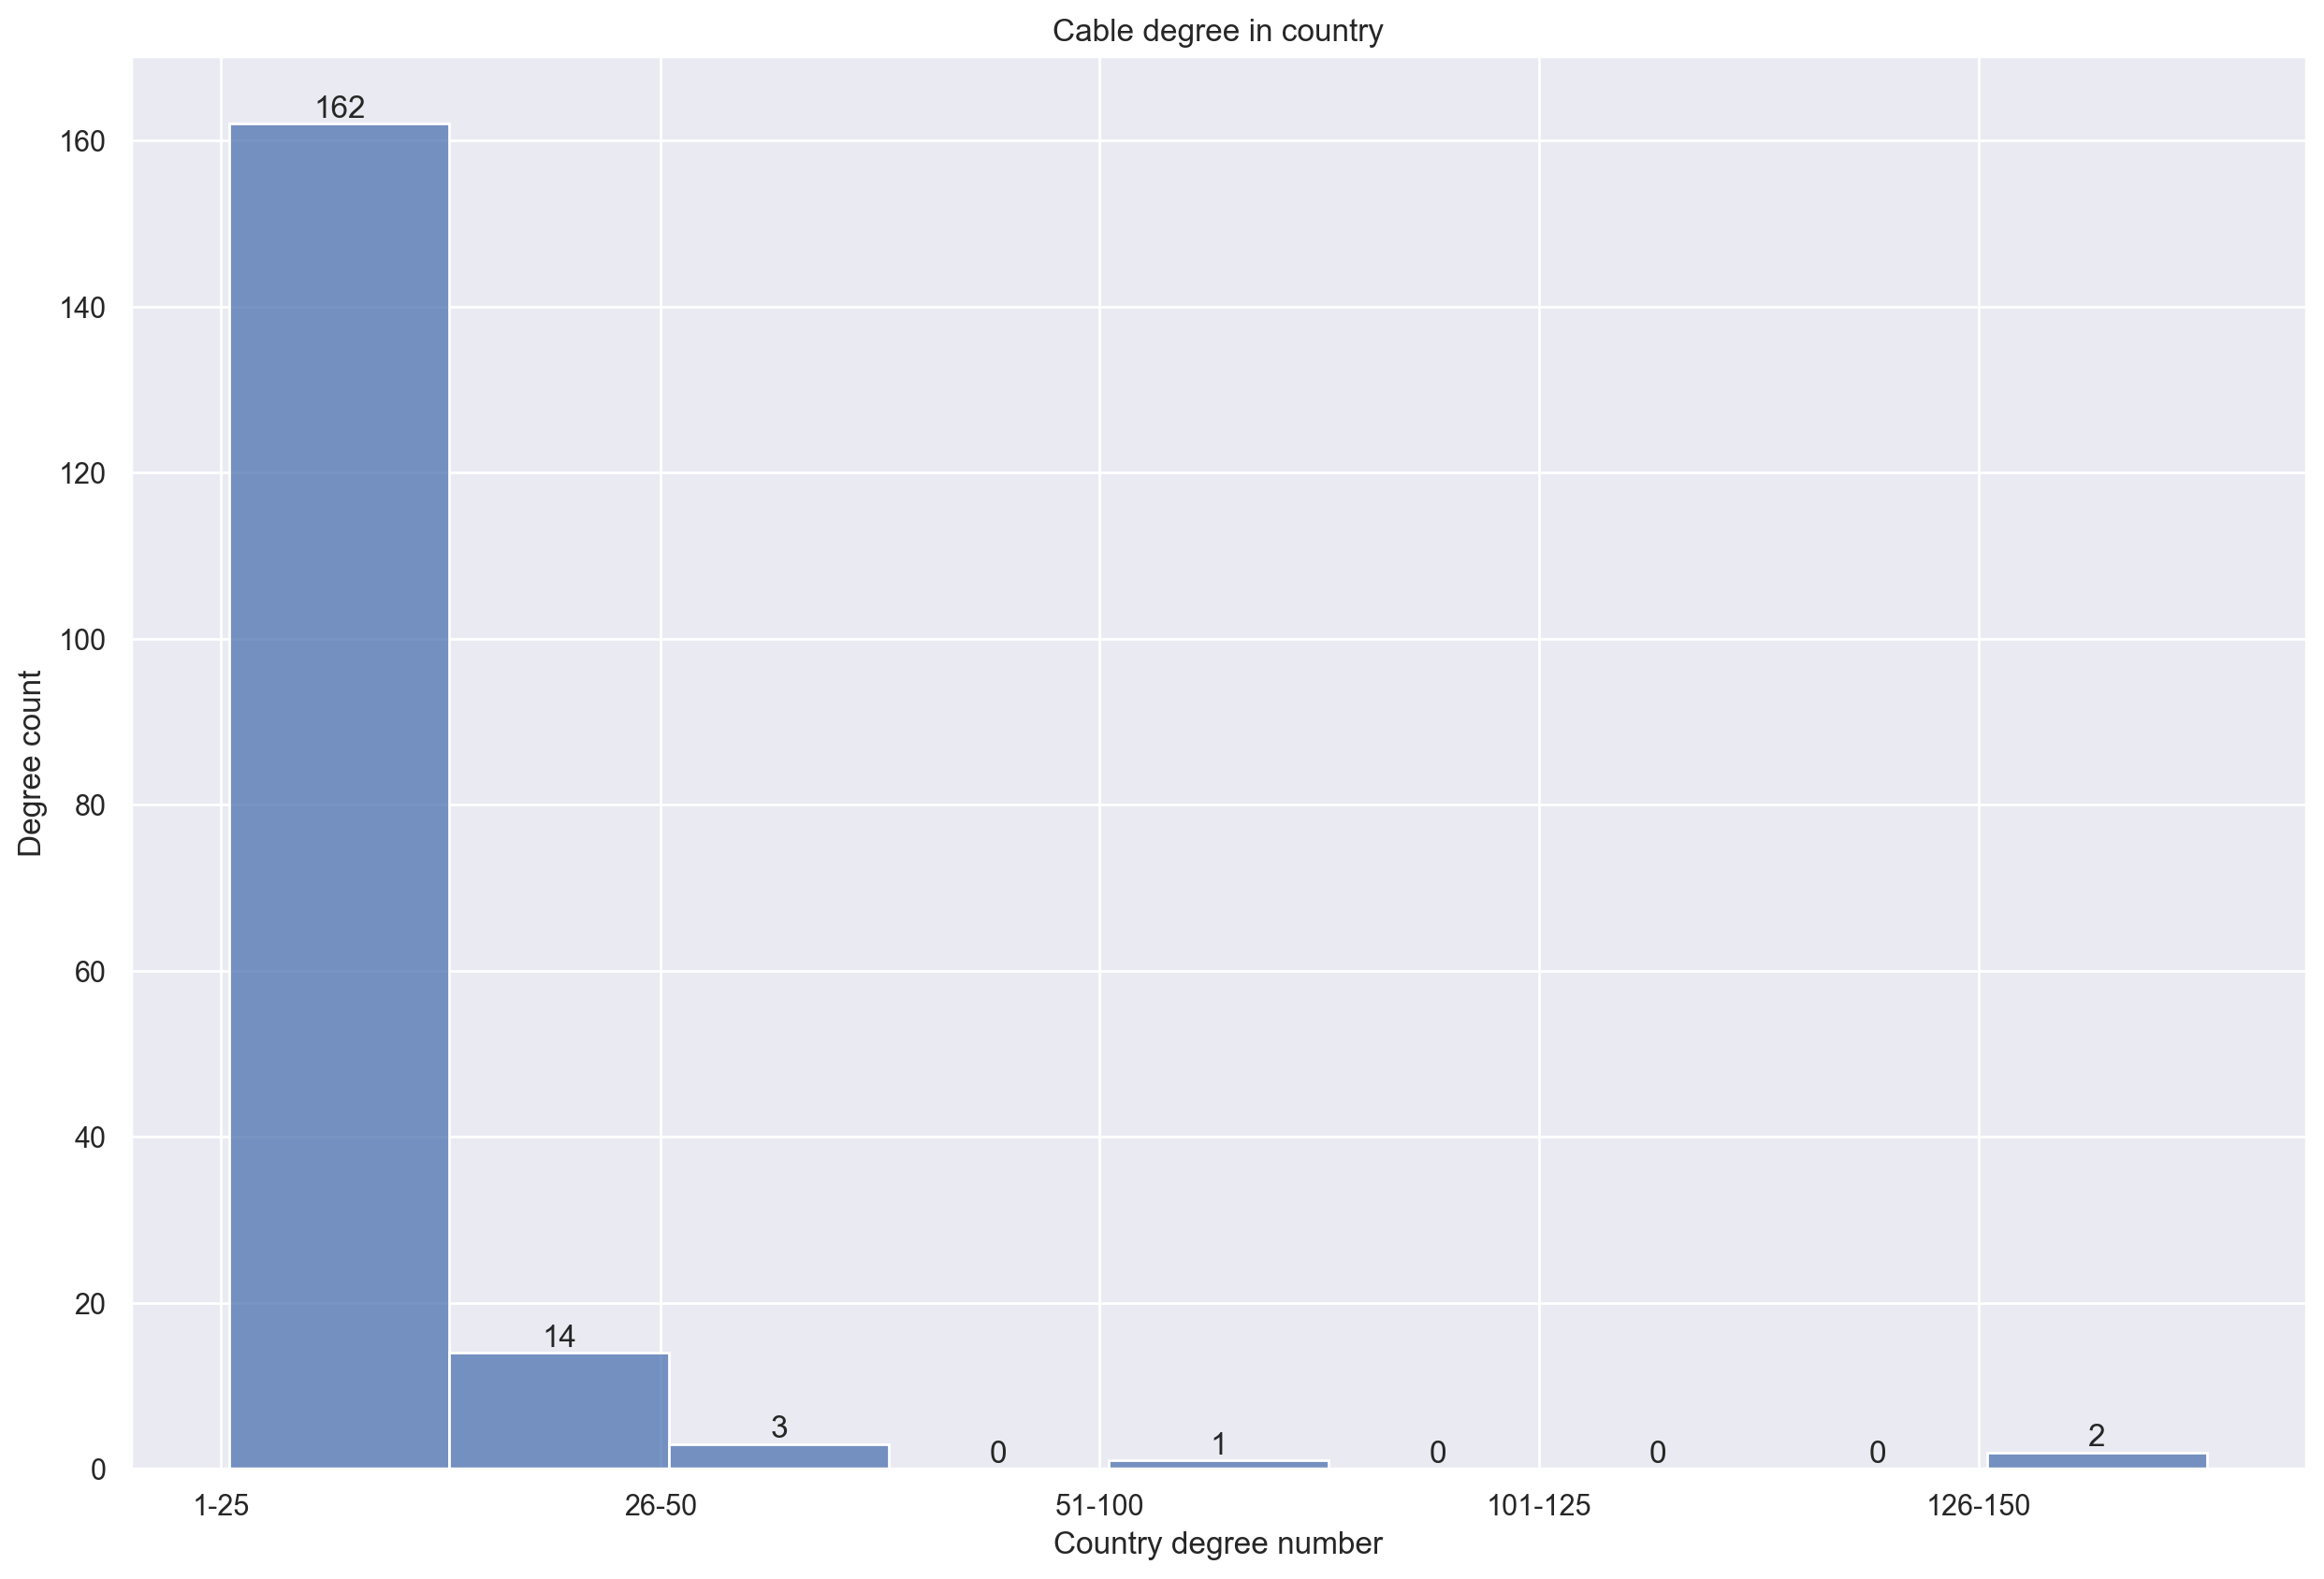

In [161]:
sns.set()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

# h = sns.histplot(country_cable_node_count['node_count'], bins=range(1,19,2),ax=ax)
h = sns.histplot(country_cable_node_count['node_count'], bins=range(1,250,25),ax=ax)
plt.xlabel('Country degree number')
plt.ylabel('Degree count')
plt.title('Cable degree in country')

ax.bar_label(ax.containers[0])
# h.set_xticks([1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5, 17.5])
h.set_xticklabels(['0-1','1-25','26-50', '51-100', '101-125', '126-150', '151-200', '201-225'])

plt.show()

In [163]:
(138+126+88)/1335

0.2636704119850187